# Generative Adverserial Network 
So here's the plan... 

I want to learn about Generative Adverserial Networks (GANs), but I don't know much about it. So let's start with this simple project to understand the basic principles of the GANs. 

Here's how I understand it so far, there are two networks fighting each other, the descriminator and the generator. The goal is to get the generator to a point where the descriminator cannot distinguish between generated and authentic data. 

So for this example, I'm following a tutorial. If you know about GANs already this will really bore you, but this is more for me anyway, so suck a big one :).

## Slight Detour

***Generative Network***
* Takes in input noise 
* Gives output similar to that of our dataset

***Descriminator Network***
* Takes in generated data
* Tries to distinguish between generated and real data
* Binary output classification between 0 and 1

It takes it's idea from MinMax from game theory: 
The minmax value is the highest value a player can be sure to get without knowing the actions of the other player. 

The formula we follow is this:
`min(D) max(G) V(D,G) = E[Log(D(x))] + E[1 - Log(D(G(z))]`

In game theory there are equillibrium positions we can reach, the ideal goal we want is 0.5, that is that the discriminator cannot tell the difference between the real data and the generated one. That's the goal

# Quadratic GANs 

To keep this simple, i'm going to make a GAN that generates a Quadratic distribution. This distribution is a simple quadratic one. We will start by making the generator.

## The Real Data 
We need a training set, to do that I'll start by making a function called "sample data" which will generate 10,000 data training data points. To do this we will randomly generate 10,000 points between 0 - 100, then we will calculate authentic y values for these data points. 

The quadratic formula we will write is `(x-5)^2 + 5` 

In [20]:
import numpy as np

def get_y(x):
    return 5 + (x-5)**2


def sample_data(n=10000):
    data = []

    x = 10 * np.random.random_sample((n,)) 

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

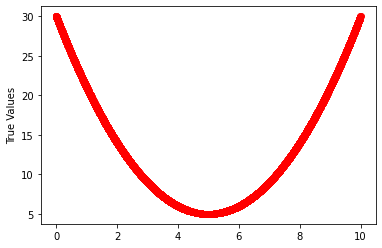

array([[ 7.07990526,  9.32600588],
       [ 7.76152053, 12.62599562],
       [ 3.4682685 ,  7.34620137],
       ...,
       [ 6.44312583,  7.08261217],
       [ 0.21686577, 27.87837304],
       [ 4.77596813,  5.05019028]])

In [21]:
import matplotlib.pyplot as plt

plt.plot([i[0] for i in data], [i[1] for i in data], 'ro')
plt.ylabel('True Values')
plt.show()
data = sample_data()
data

## Generative Network 
We make a neural network that generates a y value for a given x value. In this example we make a neural network with this architecture:

* 1 Neuron Input layer 
* 2 Hidden Layers (16 Neurones Each)
* 2 Neuron Output layer [x, y]

In [34]:
import tensorflow as tf
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.compat.v1.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.compat.v1.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.compat.v1.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.compat.v1.layers.dense(h2,2)

    return out

## Descriminator Network 
We make a neural network that tells the difference between real data and fake data. This will take in an input X which should have two values [x,y] and determines if this is a real quadratic function.

* 1 Neurone Input Layer 
* 3 Hidden Layers (16 x 16 x 2) Neurons 
* Output layer has one output neuron

In [35]:
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.compat.v1.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.compat.v1.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.compat.v1.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.compat.v1.layers.dense(h2,2)
        out = tf.compat.v1.layers.dense(h3,1)

    return out, h3

Okay, so we have a generator and a discriminator now the next step is is to create some Real samples (X) and and Noise Samples (Z), the noise samples will be sent into the generator function and the results of the generator and the real sample will be passed into the descriminator. 

In [29]:
# Disable eager execution for tensorflow placeholder 
tf.compat.v1.disable_eager_execution()
# Real Samples 
X = tf.compat.v1.placeholder(tf.float32,[None,2])
# Noise Samples
Z = tf.compat.v1.placeholder(tf.float32,[None,2])

In [39]:
G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

ValueError: Variable GAN/Generator/dense/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope?

Okay, now we need to describe the loss functions for the neural networks. For the discriminator we sue the sigmoid cross entropy I should probably look into this a bit more so i'll leave a TODO and an issue for later 

But if i have it correct so far it's the sigmoid activation function (which is the S shape) followed with a cross entropy loss function.

It's a common loss function for discrete classification.

TODO:// Finish this later go into a little more detail about the vector space differences.

In [40]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

In [44]:
gen_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Okay, so everything is ready. Now we just need to train the model 

In [56]:

import matplotlib.pyplot as plt

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

# sess = tf.Session(config=config)
sess = tf.compat.v1.Session()
tf.compat.v1.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('./iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('./feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('./feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()

Iterations: 0	 Discriminator loss: 1.7647	 Generator loss: 0.6910
Iterations: 1	 Discriminator loss: 1.5158	 Generator loss: 0.6889
Iterations: 2	 Discriminator loss: 1.3145	 Generator loss: 0.6879
Iterations: 3	 Discriminator loss: 1.1646	 Generator loss: 0.6897
Iterations: 4	 Discriminator loss: 1.0419	 Generator loss: 0.6970
Iterations: 5	 Discriminator loss: 0.9326	 Generator loss: 0.7078
Iterations: 6	 Discriminator loss: 0.8444	 Generator loss: 0.7184
Iterations: 7	 Discriminator loss: 0.7943	 Generator loss: 0.7277
Iterations: 8	 Discriminator loss: 0.7464	 Generator loss: 0.7402
Iterations: 9	 Discriminator loss: 0.7056	 Generator loss: 0.7392
Iterations: 10	 Discriminator loss: 0.6870	 Generator loss: 0.7383
Iterations: 11	 Discriminator loss: 0.6663	 Generator loss: 0.7459
Iterations: 12	 Discriminator loss: 0.6558	 Generator loss: 0.7569
Iterations: 13	 Discriminator loss: 0.6475	 Generator loss: 0.7719
Iterations: 14	 Discriminator loss: 0.6330	 Generator loss: 0.7972
Itera

Iterations: 137	 Discriminator loss: 1.3737	 Generator loss: 0.6348
Iterations: 138	 Discriminator loss: 1.3789	 Generator loss: 0.6159
Iterations: 139	 Discriminator loss: 1.3761	 Generator loss: 0.6028
Iterations: 140	 Discriminator loss: 1.3720	 Generator loss: 0.6426
Iterations: 141	 Discriminator loss: 1.3657	 Generator loss: 0.6559
Iterations: 142	 Discriminator loss: 1.3816	 Generator loss: 0.6333
Iterations: 143	 Discriminator loss: 1.3789	 Generator loss: 0.6226
Iterations: 144	 Discriminator loss: 1.3872	 Generator loss: 0.6236
Iterations: 145	 Discriminator loss: 1.3655	 Generator loss: 0.5994
Iterations: 146	 Discriminator loss: 1.3711	 Generator loss: 0.6871
Iterations: 147	 Discriminator loss: 1.3785	 Generator loss: 0.6494
Iterations: 148	 Discriminator loss: 1.3835	 Generator loss: 0.5997
Iterations: 149	 Discriminator loss: 1.3761	 Generator loss: 0.6783
Iterations: 150	 Discriminator loss: 1.3592	 Generator loss: 0.6774
Iterations: 151	 Discriminator loss: 1.3980	 Gen

Iterations: 261	 Discriminator loss: 1.3741	 Generator loss: 0.7202
Iterations: 262	 Discriminator loss: 1.3803	 Generator loss: 0.7154
Iterations: 263	 Discriminator loss: 1.3775	 Generator loss: 0.7393
Iterations: 264	 Discriminator loss: 1.3787	 Generator loss: 0.7286
Iterations: 265	 Discriminator loss: 1.3755	 Generator loss: 0.7516
Iterations: 266	 Discriminator loss: 1.3924	 Generator loss: 0.8056
Iterations: 267	 Discriminator loss: 1.3774	 Generator loss: 0.7006
Iterations: 268	 Discriminator loss: 1.3728	 Generator loss: 0.6840
Iterations: 269	 Discriminator loss: 1.3817	 Generator loss: 0.6223
Iterations: 270	 Discriminator loss: 1.3785	 Generator loss: 0.6729
Iterations: 271	 Discriminator loss: 1.3663	 Generator loss: 0.7042
Iterations: 272	 Discriminator loss: 1.3727	 Generator loss: 0.6781
Iterations: 273	 Discriminator loss: 1.3786	 Generator loss: 0.6479
Iterations: 274	 Discriminator loss: 1.3704	 Generator loss: 0.6868
Iterations: 275	 Discriminator loss: 1.3755	 Gen

Iterations: 389	 Discriminator loss: 1.3839	 Generator loss: 0.7247
Iterations: 390	 Discriminator loss: 1.3872	 Generator loss: 0.7329
Iterations: 391	 Discriminator loss: 1.3738	 Generator loss: 0.7214
Iterations: 392	 Discriminator loss: 1.3818	 Generator loss: 0.6755
Iterations: 393	 Discriminator loss: 1.3823	 Generator loss: 0.6675
Iterations: 394	 Discriminator loss: 1.3789	 Generator loss: 0.6782
Iterations: 395	 Discriminator loss: 1.3780	 Generator loss: 0.6469
Iterations: 396	 Discriminator loss: 1.3567	 Generator loss: 0.7399
Iterations: 397	 Discriminator loss: 1.3766	 Generator loss: 0.7250
Iterations: 398	 Discriminator loss: 1.3766	 Generator loss: 0.6274
Iterations: 399	 Discriminator loss: 1.3614	 Generator loss: 0.6492
Iterations: 400	 Discriminator loss: 1.3630	 Generator loss: 0.6559
Iterations: 401	 Discriminator loss: 1.3831	 Generator loss: 0.6510
Iterations: 402	 Discriminator loss: 1.3778	 Generator loss: 0.6770
Iterations: 403	 Discriminator loss: 1.3822	 Gen

Iterations: 521	 Discriminator loss: 1.3849	 Generator loss: 0.7336
Iterations: 522	 Discriminator loss: 1.3761	 Generator loss: 0.7269
Iterations: 523	 Discriminator loss: 1.3694	 Generator loss: 0.7214
Iterations: 524	 Discriminator loss: 1.3838	 Generator loss: 0.7036
Iterations: 525	 Discriminator loss: 1.3863	 Generator loss: 0.7656
Iterations: 526	 Discriminator loss: 1.3809	 Generator loss: 0.6938
Iterations: 527	 Discriminator loss: 1.3843	 Generator loss: 0.6496
Iterations: 528	 Discriminator loss: 1.3743	 Generator loss: 0.7048
Iterations: 529	 Discriminator loss: 1.3806	 Generator loss: 0.7113
Iterations: 530	 Discriminator loss: 1.3781	 Generator loss: 0.7384
Iterations: 531	 Discriminator loss: 1.3739	 Generator loss: 0.6682
Iterations: 532	 Discriminator loss: 1.3793	 Generator loss: 0.6974
Iterations: 533	 Discriminator loss: 1.3723	 Generator loss: 0.6711
Iterations: 534	 Discriminator loss: 1.3736	 Generator loss: 0.6898
Iterations: 535	 Discriminator loss: 1.3776	 Gen

Iterations: 645	 Discriminator loss: 1.3886	 Generator loss: 0.7501
Iterations: 646	 Discriminator loss: 1.3770	 Generator loss: 0.7258
Iterations: 647	 Discriminator loss: 1.3735	 Generator loss: 0.7385
Iterations: 648	 Discriminator loss: 1.3613	 Generator loss: 0.7055
Iterations: 649	 Discriminator loss: 1.3758	 Generator loss: 0.7065
Iterations: 650	 Discriminator loss: 1.3802	 Generator loss: 0.7563
Iterations: 651	 Discriminator loss: 1.3594	 Generator loss: 0.7597
Iterations: 652	 Discriminator loss: 1.3568	 Generator loss: 0.7002
Iterations: 653	 Discriminator loss: 1.3736	 Generator loss: 0.6949
Iterations: 654	 Discriminator loss: 1.3749	 Generator loss: 0.7011
Iterations: 655	 Discriminator loss: 1.3817	 Generator loss: 0.6235
Iterations: 656	 Discriminator loss: 1.3720	 Generator loss: 0.6706
Iterations: 657	 Discriminator loss: 1.3789	 Generator loss: 0.6939
Iterations: 658	 Discriminator loss: 1.3614	 Generator loss: 0.7913
Iterations: 659	 Discriminator loss: 1.3664	 Gen

Iterations: 776	 Discriminator loss: 1.3804	 Generator loss: 0.5953
Iterations: 777	 Discriminator loss: 1.3811	 Generator loss: 0.6356
Iterations: 778	 Discriminator loss: 1.3696	 Generator loss: 0.6635
Iterations: 779	 Discriminator loss: 1.3696	 Generator loss: 0.6162
Iterations: 780	 Discriminator loss: 1.3800	 Generator loss: 0.6256
Iterations: 781	 Discriminator loss: 1.3771	 Generator loss: 0.6398
Iterations: 782	 Discriminator loss: 1.3764	 Generator loss: 0.6284
Iterations: 783	 Discriminator loss: 1.3779	 Generator loss: 0.6239
Iterations: 784	 Discriminator loss: 1.3784	 Generator loss: 0.6033
Iterations: 785	 Discriminator loss: 1.3818	 Generator loss: 0.6610
Iterations: 786	 Discriminator loss: 1.3765	 Generator loss: 0.7008
Iterations: 787	 Discriminator loss: 1.3662	 Generator loss: 0.6298
Iterations: 788	 Discriminator loss: 1.3813	 Generator loss: 0.6588
Iterations: 789	 Discriminator loss: 1.3874	 Generator loss: 0.6641
Iterations: 790	 Discriminator loss: 1.3711	 Gen

Iterations: 904	 Discriminator loss: 1.3550	 Generator loss: 0.7995
Iterations: 905	 Discriminator loss: 1.3487	 Generator loss: 0.7437
Iterations: 906	 Discriminator loss: 1.3689	 Generator loss: 0.7577
Iterations: 907	 Discriminator loss: 1.3721	 Generator loss: 0.7832
Iterations: 908	 Discriminator loss: 1.3866	 Generator loss: 0.7754
Iterations: 909	 Discriminator loss: 1.3642	 Generator loss: 0.7042
Iterations: 910	 Discriminator loss: 1.3650	 Generator loss: 0.6634
Iterations: 911	 Discriminator loss: 1.3878	 Generator loss: 0.6291
Iterations: 912	 Discriminator loss: 1.3864	 Generator loss: 0.6570
Iterations: 913	 Discriminator loss: 1.3805	 Generator loss: 0.6186
Iterations: 914	 Discriminator loss: 1.3755	 Generator loss: 0.5856
Iterations: 915	 Discriminator loss: 1.3682	 Generator loss: 0.6442
Iterations: 916	 Discriminator loss: 1.3679	 Generator loss: 0.6368
Iterations: 917	 Discriminator loss: 1.3703	 Generator loss: 0.6197
Iterations: 918	 Discriminator loss: 1.3737	 Gen

Iterations: 1032	 Discriminator loss: 1.3572	 Generator loss: 0.6008
Iterations: 1033	 Discriminator loss: 1.3348	 Generator loss: 0.6631
Iterations: 1034	 Discriminator loss: 1.3436	 Generator loss: 0.6061
Iterations: 1035	 Discriminator loss: 1.3600	 Generator loss: 0.5985
Iterations: 1036	 Discriminator loss: 1.3617	 Generator loss: 0.6184
Iterations: 1037	 Discriminator loss: 1.3596	 Generator loss: 0.5870
Iterations: 1038	 Discriminator loss: 1.3673	 Generator loss: 0.5714
Iterations: 1039	 Discriminator loss: 1.3337	 Generator loss: 0.6499
Iterations: 1040	 Discriminator loss: 1.3572	 Generator loss: 0.5808
Iterations: 1041	 Discriminator loss: 1.3454	 Generator loss: 0.6185
Iterations: 1042	 Discriminator loss: 1.3447	 Generator loss: 0.6182
Iterations: 1043	 Discriminator loss: 1.3462	 Generator loss: 0.6219
Iterations: 1044	 Discriminator loss: 1.3587	 Generator loss: 0.6249
Iterations: 1045	 Discriminator loss: 1.3595	 Generator loss: 0.5712
Iterations: 1046	 Discriminator lo

Iterations: 1167	 Discriminator loss: 1.3840	 Generator loss: 0.5929
Iterations: 1168	 Discriminator loss: 1.3421	 Generator loss: 0.5854
Iterations: 1169	 Discriminator loss: 1.3488	 Generator loss: 0.6098
Iterations: 1170	 Discriminator loss: 1.3440	 Generator loss: 0.5793
Iterations: 1171	 Discriminator loss: 1.3618	 Generator loss: 0.5923
Iterations: 1172	 Discriminator loss: 1.3387	 Generator loss: 0.5850
Iterations: 1173	 Discriminator loss: 1.3544	 Generator loss: 0.6312
Iterations: 1174	 Discriminator loss: 1.3546	 Generator loss: 0.6209
Iterations: 1175	 Discriminator loss: 1.4117	 Generator loss: 0.5614
Iterations: 1176	 Discriminator loss: 1.3444	 Generator loss: 0.6417
Iterations: 1177	 Discriminator loss: 1.3523	 Generator loss: 0.6387
Iterations: 1178	 Discriminator loss: 1.4034	 Generator loss: 0.5840
Iterations: 1179	 Discriminator loss: 1.4029	 Generator loss: 0.6004
Iterations: 1180	 Discriminator loss: 1.3978	 Generator loss: 0.6143
Iterations: 1181	 Discriminator lo

Iterations: 1299	 Discriminator loss: 1.3898	 Generator loss: 0.5993
Iterations: 1300	 Discriminator loss: 1.3916	 Generator loss: 0.6093
Iterations: 1301	 Discriminator loss: 1.3704	 Generator loss: 0.6297
Iterations: 1302	 Discriminator loss: 1.3833	 Generator loss: 0.6087
Iterations: 1303	 Discriminator loss: 1.3441	 Generator loss: 0.6063
Iterations: 1304	 Discriminator loss: 1.3506	 Generator loss: 0.5692
Iterations: 1305	 Discriminator loss: 1.3644	 Generator loss: 0.5955
Iterations: 1306	 Discriminator loss: 1.3455	 Generator loss: 0.5811
Iterations: 1307	 Discriminator loss: 1.3613	 Generator loss: 0.6258
Iterations: 1308	 Discriminator loss: 1.4078	 Generator loss: 0.5761
Iterations: 1309	 Discriminator loss: 1.3720	 Generator loss: 0.6123
Iterations: 1310	 Discriminator loss: 1.3628	 Generator loss: 0.5995
Iterations: 1311	 Discriminator loss: 1.3604	 Generator loss: 0.6021
Iterations: 1312	 Discriminator loss: 1.3563	 Generator loss: 0.6132
Iterations: 1313	 Discriminator lo

Iterations: 1423	 Discriminator loss: 1.3671	 Generator loss: 0.6061
Iterations: 1424	 Discriminator loss: 1.3710	 Generator loss: 0.5853
Iterations: 1425	 Discriminator loss: 1.3585	 Generator loss: 0.6475
Iterations: 1426	 Discriminator loss: 1.3759	 Generator loss: 0.6182
Iterations: 1427	 Discriminator loss: 1.3843	 Generator loss: 0.5998
Iterations: 1428	 Discriminator loss: 1.3748	 Generator loss: 0.6450
Iterations: 1429	 Discriminator loss: 1.3800	 Generator loss: 0.5956
Iterations: 1430	 Discriminator loss: 1.3343	 Generator loss: 0.6066
Iterations: 1431	 Discriminator loss: 1.3722	 Generator loss: 0.6179
Iterations: 1432	 Discriminator loss: 1.3611	 Generator loss: 0.6063
Iterations: 1433	 Discriminator loss: 1.3880	 Generator loss: 0.6069
Iterations: 1434	 Discriminator loss: 1.3624	 Generator loss: 0.6136
Iterations: 1435	 Discriminator loss: 1.3565	 Generator loss: 0.5655
Iterations: 1436	 Discriminator loss: 1.3699	 Generator loss: 0.6173
Iterations: 1437	 Discriminator lo

Iterations: 1547	 Discriminator loss: 1.3365	 Generator loss: 0.5523
Iterations: 1548	 Discriminator loss: 1.3479	 Generator loss: 0.5727
Iterations: 1549	 Discriminator loss: 1.3680	 Generator loss: 0.6184
Iterations: 1550	 Discriminator loss: 1.3557	 Generator loss: 0.6880
Iterations: 1551	 Discriminator loss: 1.3544	 Generator loss: 0.6502
Iterations: 1552	 Discriminator loss: 1.3629	 Generator loss: 0.6086
Iterations: 1553	 Discriminator loss: 1.3780	 Generator loss: 0.6178
Iterations: 1554	 Discriminator loss: 1.3573	 Generator loss: 0.6361
Iterations: 1555	 Discriminator loss: 1.3533	 Generator loss: 0.6080
Iterations: 1556	 Discriminator loss: 1.3781	 Generator loss: 0.6046
Iterations: 1557	 Discriminator loss: 1.3278	 Generator loss: 0.5877
Iterations: 1558	 Discriminator loss: 1.3387	 Generator loss: 0.5903
Iterations: 1559	 Discriminator loss: 1.3473	 Generator loss: 0.5858
Iterations: 1560	 Discriminator loss: 1.3582	 Generator loss: 0.6428
Iterations: 1561	 Discriminator lo

Iterations: 1671	 Discriminator loss: 1.3747	 Generator loss: 0.6069
Iterations: 1672	 Discriminator loss: 1.3446	 Generator loss: 0.5813
Iterations: 1673	 Discriminator loss: 1.3214	 Generator loss: 0.5301
Iterations: 1674	 Discriminator loss: 1.3033	 Generator loss: 0.5576
Iterations: 1675	 Discriminator loss: 1.3128	 Generator loss: 0.5564
Iterations: 1676	 Discriminator loss: 1.3738	 Generator loss: 0.5709
Iterations: 1677	 Discriminator loss: 1.3610	 Generator loss: 0.5919
Iterations: 1678	 Discriminator loss: 1.3804	 Generator loss: 0.5871
Iterations: 1679	 Discriminator loss: 1.3708	 Generator loss: 0.6322
Iterations: 1680	 Discriminator loss: 1.3843	 Generator loss: 0.5962
Iterations: 1681	 Discriminator loss: 1.3742	 Generator loss: 0.5919
Iterations: 1682	 Discriminator loss: 1.3616	 Generator loss: 0.5886
Iterations: 1683	 Discriminator loss: 1.3227	 Generator loss: 0.5539
Iterations: 1684	 Discriminator loss: 1.3048	 Generator loss: 0.5337
Iterations: 1685	 Discriminator lo

Iterations: 1790	 Discriminator loss: 1.3032	 Generator loss: 0.5516
Iterations: 1791	 Discriminator loss: 1.3371	 Generator loss: 0.5435
Iterations: 1792	 Discriminator loss: 1.3081	 Generator loss: 0.5686
Iterations: 1793	 Discriminator loss: 1.3491	 Generator loss: 0.6111
Iterations: 1794	 Discriminator loss: 1.3506	 Generator loss: 0.6472
Iterations: 1795	 Discriminator loss: 1.3520	 Generator loss: 0.6219
Iterations: 1796	 Discriminator loss: 1.3513	 Generator loss: 0.5827
Iterations: 1797	 Discriminator loss: 1.3490	 Generator loss: 0.5785
Iterations: 1798	 Discriminator loss: 1.3916	 Generator loss: 0.5456
Iterations: 1799	 Discriminator loss: 1.3916	 Generator loss: 0.5422
Iterations: 1800	 Discriminator loss: 1.2824	 Generator loss: 0.5503
Iterations: 1801	 Discriminator loss: 1.3135	 Generator loss: 0.5386
Iterations: 1802	 Discriminator loss: 1.3115	 Generator loss: 0.5704
Iterations: 1803	 Discriminator loss: 1.3276	 Generator loss: 0.5422
Iterations: 1804	 Discriminator lo

Iterations: 1926	 Discriminator loss: 1.3260	 Generator loss: 0.5571
Iterations: 1927	 Discriminator loss: 1.3203	 Generator loss: 0.5515
Iterations: 1928	 Discriminator loss: 1.3040	 Generator loss: 0.5472
Iterations: 1929	 Discriminator loss: 1.3222	 Generator loss: 0.5156
Iterations: 1930	 Discriminator loss: 1.2881	 Generator loss: 0.5205
Iterations: 1931	 Discriminator loss: 1.3304	 Generator loss: 0.5417
Iterations: 1932	 Discriminator loss: 1.2951	 Generator loss: 0.5160
Iterations: 1933	 Discriminator loss: 1.2650	 Generator loss: 0.5914
Iterations: 1934	 Discriminator loss: 1.2942	 Generator loss: 0.5362
Iterations: 1935	 Discriminator loss: 1.2818	 Generator loss: 0.6027
Iterations: 1936	 Discriminator loss: 1.2975	 Generator loss: 0.5436
Iterations: 1937	 Discriminator loss: 1.3027	 Generator loss: 0.5126
Iterations: 1938	 Discriminator loss: 1.3840	 Generator loss: 0.8625
Iterations: 1939	 Discriminator loss: 1.2624	 Generator loss: 0.7043
Iterations: 1940	 Discriminator lo

Iterations: 2055	 Discriminator loss: 1.4027	 Generator loss: 0.5933
Iterations: 2056	 Discriminator loss: 1.3056	 Generator loss: 0.5716
Iterations: 2057	 Discriminator loss: 1.3743	 Generator loss: 0.5562
Iterations: 2058	 Discriminator loss: 1.3815	 Generator loss: 0.5429
Iterations: 2059	 Discriminator loss: 1.3749	 Generator loss: 0.6136
Iterations: 2060	 Discriminator loss: 1.3701	 Generator loss: 0.5460
Iterations: 2061	 Discriminator loss: 1.2816	 Generator loss: 0.5347
Iterations: 2062	 Discriminator loss: 1.2884	 Generator loss: 0.5323
Iterations: 2063	 Discriminator loss: 1.2669	 Generator loss: 0.5715
Iterations: 2064	 Discriminator loss: 1.3536	 Generator loss: 0.5796
Iterations: 2065	 Discriminator loss: 1.3663	 Generator loss: 0.5871
Iterations: 2066	 Discriminator loss: 1.3740	 Generator loss: 0.5937
Iterations: 2067	 Discriminator loss: 1.3808	 Generator loss: 0.5958
Iterations: 2068	 Discriminator loss: 1.3465	 Generator loss: 0.5556
Iterations: 2069	 Discriminator lo

Iterations: 2181	 Discriminator loss: 1.3346	 Generator loss: 0.5407
Iterations: 2182	 Discriminator loss: 1.2969	 Generator loss: 0.5219
Iterations: 2183	 Discriminator loss: 1.3106	 Generator loss: 0.5188
Iterations: 2184	 Discriminator loss: 1.2591	 Generator loss: 0.5291
Iterations: 2185	 Discriminator loss: 1.3537	 Generator loss: 0.5697
Iterations: 2186	 Discriminator loss: 1.3501	 Generator loss: 0.5785
Iterations: 2187	 Discriminator loss: 1.3118	 Generator loss: 0.5095
Iterations: 2188	 Discriminator loss: 1.2365	 Generator loss: 0.5987
Iterations: 2189	 Discriminator loss: 1.2937	 Generator loss: 0.4868
Iterations: 2190	 Discriminator loss: 1.2624	 Generator loss: 0.5807
Iterations: 2191	 Discriminator loss: 1.3020	 Generator loss: 0.5284
Iterations: 2192	 Discriminator loss: 1.2669	 Generator loss: 0.4913
Iterations: 2193	 Discriminator loss: 1.2806	 Generator loss: 0.4882
Iterations: 2194	 Discriminator loss: 1.2752	 Generator loss: 0.5369
Iterations: 2195	 Discriminator lo

Iterations: 2304	 Discriminator loss: 1.2528	 Generator loss: 0.5236
Iterations: 2305	 Discriminator loss: 1.2941	 Generator loss: 0.5220
Iterations: 2306	 Discriminator loss: 1.2858	 Generator loss: 0.5525
Iterations: 2307	 Discriminator loss: 1.3585	 Generator loss: 0.5766
Iterations: 2308	 Discriminator loss: 1.3632	 Generator loss: 0.5875
Iterations: 2309	 Discriminator loss: 1.3562	 Generator loss: 0.5712
Iterations: 2310	 Discriminator loss: 1.3608	 Generator loss: 0.5720
Iterations: 2311	 Discriminator loss: 1.2747	 Generator loss: 0.5055
Iterations: 2312	 Discriminator loss: 1.2842	 Generator loss: 0.5310
Iterations: 2313	 Discriminator loss: 1.2488	 Generator loss: 0.5414
Iterations: 2314	 Discriminator loss: 1.3431	 Generator loss: 0.5920
Iterations: 2315	 Discriminator loss: 1.3756	 Generator loss: 0.5845
Iterations: 2316	 Discriminator loss: 1.3588	 Generator loss: 0.5547
Iterations: 2317	 Discriminator loss: 1.4200	 Generator loss: 0.5716
Iterations: 2318	 Discriminator lo

Iterations: 2425	 Discriminator loss: 1.2834	 Generator loss: 0.5615
Iterations: 2426	 Discriminator loss: 1.3181	 Generator loss: 0.7263
Iterations: 2427	 Discriminator loss: 1.3825	 Generator loss: 0.7984
Iterations: 2428	 Discriminator loss: 1.3585	 Generator loss: 0.7822
Iterations: 2429	 Discriminator loss: 1.3622	 Generator loss: 0.9202
Iterations: 2430	 Discriminator loss: 1.2988	 Generator loss: 0.5239
Iterations: 2431	 Discriminator loss: 1.2663	 Generator loss: 0.4655
Iterations: 2432	 Discriminator loss: 1.3963	 Generator loss: 0.5421
Iterations: 2433	 Discriminator loss: 1.3091	 Generator loss: 0.5739
Iterations: 2434	 Discriminator loss: 1.2913	 Generator loss: 0.5171
Iterations: 2435	 Discriminator loss: 1.2862	 Generator loss: 0.5443
Iterations: 2436	 Discriminator loss: 1.3306	 Generator loss: 0.6173
Iterations: 2437	 Discriminator loss: 1.3457	 Generator loss: 0.5667
Iterations: 2438	 Discriminator loss: 1.2739	 Generator loss: 0.5130
Iterations: 2439	 Discriminator lo

Iterations: 2555	 Discriminator loss: 1.4216	 Generator loss: 0.5627
Iterations: 2556	 Discriminator loss: 1.2782	 Generator loss: 0.5569
Iterations: 2557	 Discriminator loss: 1.2661	 Generator loss: 0.5258
Iterations: 2558	 Discriminator loss: 1.2758	 Generator loss: 0.5242
Iterations: 2559	 Discriminator loss: 1.2698	 Generator loss: 0.5131
Iterations: 2560	 Discriminator loss: 1.2734	 Generator loss: 0.5350
Iterations: 2561	 Discriminator loss: 1.2763	 Generator loss: 0.5139
Iterations: 2562	 Discriminator loss: 1.2737	 Generator loss: 0.4932
Iterations: 2563	 Discriminator loss: 1.3885	 Generator loss: 0.9014
Iterations: 2564	 Discriminator loss: 1.2934	 Generator loss: 0.7384
Iterations: 2565	 Discriminator loss: 1.2622	 Generator loss: 0.4989
Iterations: 2566	 Discriminator loss: 1.2783	 Generator loss: 0.5862
Iterations: 2567	 Discriminator loss: 1.2564	 Generator loss: 0.5194
Iterations: 2568	 Discriminator loss: 1.2829	 Generator loss: 0.5129
Iterations: 2569	 Discriminator lo

Iterations: 2683	 Discriminator loss: 1.2686	 Generator loss: 0.5282
Iterations: 2684	 Discriminator loss: 1.2763	 Generator loss: 0.5250
Iterations: 2685	 Discriminator loss: 1.2758	 Generator loss: 0.5701
Iterations: 2686	 Discriminator loss: 1.3722	 Generator loss: 0.5011
Iterations: 2687	 Discriminator loss: 1.3803	 Generator loss: 0.5904
Iterations: 2688	 Discriminator loss: 1.3739	 Generator loss: 0.5884
Iterations: 2689	 Discriminator loss: 1.2769	 Generator loss: 0.5368
Iterations: 2690	 Discriminator loss: 1.3250	 Generator loss: 0.6560
Iterations: 2691	 Discriminator loss: 1.3219	 Generator loss: 0.5388
Iterations: 2692	 Discriminator loss: 1.2130	 Generator loss: 0.4880
Iterations: 2693	 Discriminator loss: 1.2524	 Generator loss: 0.5176
Iterations: 2694	 Discriminator loss: 1.3038	 Generator loss: 0.5149
Iterations: 2695	 Discriminator loss: 1.2674	 Generator loss: 0.5441
Iterations: 2696	 Discriminator loss: 1.3663	 Generator loss: 0.6412
Iterations: 2697	 Discriminator lo

Iterations: 2811	 Discriminator loss: 1.2420	 Generator loss: 0.4938
Iterations: 2812	 Discriminator loss: 1.3419	 Generator loss: 0.6126
Iterations: 2813	 Discriminator loss: 1.3281	 Generator loss: 0.5800
Iterations: 2814	 Discriminator loss: 1.3814	 Generator loss: 0.5681
Iterations: 2815	 Discriminator loss: 1.3168	 Generator loss: 0.5436
Iterations: 2816	 Discriminator loss: 1.3629	 Generator loss: 0.5628
Iterations: 2817	 Discriminator loss: 1.3529	 Generator loss: 0.5695
Iterations: 2818	 Discriminator loss: 1.3460	 Generator loss: 0.5974
Iterations: 2819	 Discriminator loss: 1.3423	 Generator loss: 0.5537
Iterations: 2820	 Discriminator loss: 1.3603	 Generator loss: 0.6165
Iterations: 2821	 Discriminator loss: 1.3825	 Generator loss: 0.5689
Iterations: 2822	 Discriminator loss: 1.3418	 Generator loss: 0.5669
Iterations: 2823	 Discriminator loss: 1.2643	 Generator loss: 0.5157
Iterations: 2824	 Discriminator loss: 1.3495	 Generator loss: 0.7199
Iterations: 2825	 Discriminator lo

Iterations: 2931	 Discriminator loss: 1.3293	 Generator loss: 0.5680
Iterations: 2932	 Discriminator loss: 1.2894	 Generator loss: 0.5616
Iterations: 2933	 Discriminator loss: 1.3540	 Generator loss: 0.6325
Iterations: 2934	 Discriminator loss: 1.3315	 Generator loss: 0.6135
Iterations: 2935	 Discriminator loss: 1.3633	 Generator loss: 0.5854
Iterations: 2936	 Discriminator loss: 1.3492	 Generator loss: 0.5733
Iterations: 2937	 Discriminator loss: 1.2400	 Generator loss: 0.5082
Iterations: 2938	 Discriminator loss: 1.2380	 Generator loss: 0.5135
Iterations: 2939	 Discriminator loss: 1.2591	 Generator loss: 0.5274
Iterations: 2940	 Discriminator loss: 1.2611	 Generator loss: 0.5418
Iterations: 2941	 Discriminator loss: 1.2618	 Generator loss: 0.5653
Iterations: 2942	 Discriminator loss: 1.3518	 Generator loss: 0.6299
Iterations: 2943	 Discriminator loss: 1.3960	 Generator loss: 0.5771
Iterations: 2944	 Discriminator loss: 1.3567	 Generator loss: 0.5980
Iterations: 2945	 Discriminator lo

Iterations: 3055	 Discriminator loss: 1.3029	 Generator loss: 0.5662
Iterations: 3056	 Discriminator loss: 1.2337	 Generator loss: 0.5895
Iterations: 3057	 Discriminator loss: 1.2653	 Generator loss: 0.5075
Iterations: 3058	 Discriminator loss: 1.2704	 Generator loss: 0.5364
Iterations: 3059	 Discriminator loss: 1.2527	 Generator loss: 0.5353
Iterations: 3060	 Discriminator loss: 1.3329	 Generator loss: 0.6671
Iterations: 3061	 Discriminator loss: 1.4059	 Generator loss: 0.5611
Iterations: 3062	 Discriminator loss: 1.3813	 Generator loss: 0.6169
Iterations: 3063	 Discriminator loss: 1.2906	 Generator loss: 0.5502
Iterations: 3064	 Discriminator loss: 1.2439	 Generator loss: 0.5044
Iterations: 3065	 Discriminator loss: 1.2461	 Generator loss: 0.5489
Iterations: 3066	 Discriminator loss: 1.2632	 Generator loss: 0.5259
Iterations: 3067	 Discriminator loss: 1.2817	 Generator loss: 0.5179
Iterations: 3068	 Discriminator loss: 1.2590	 Generator loss: 0.5474
Iterations: 3069	 Discriminator lo

Iterations: 3180	 Discriminator loss: 1.2602	 Generator loss: 0.5557
Iterations: 3181	 Discriminator loss: 1.2727	 Generator loss: 0.5315
Iterations: 3182	 Discriminator loss: 1.2564	 Generator loss: 0.6171
Iterations: 3183	 Discriminator loss: 1.3287	 Generator loss: 0.5973
Iterations: 3184	 Discriminator loss: 1.3530	 Generator loss: 0.6113
Iterations: 3185	 Discriminator loss: 1.3023	 Generator loss: 0.5337
Iterations: 3186	 Discriminator loss: 1.3423	 Generator loss: 0.6021
Iterations: 3187	 Discriminator loss: 1.3594	 Generator loss: 0.6090
Iterations: 3188	 Discriminator loss: 1.3318	 Generator loss: 0.5947
Iterations: 3189	 Discriminator loss: 1.2593	 Generator loss: 0.5317
Iterations: 3190	 Discriminator loss: 1.2028	 Generator loss: 0.5021
Iterations: 3191	 Discriminator loss: 1.2205	 Generator loss: 0.4947
Iterations: 3192	 Discriminator loss: 1.2611	 Generator loss: 0.5433
Iterations: 3193	 Discriminator loss: 1.2540	 Generator loss: 0.5348
Iterations: 3194	 Discriminator lo

Iterations: 3304	 Discriminator loss: 1.3534	 Generator loss: 0.6851
Iterations: 3305	 Discriminator loss: 1.3479	 Generator loss: 0.5606
Iterations: 3306	 Discriminator loss: 1.2882	 Generator loss: 0.6031
Iterations: 3307	 Discriminator loss: 1.3339	 Generator loss: 0.5917
Iterations: 3308	 Discriminator loss: 1.3761	 Generator loss: 0.5358
Iterations: 3309	 Discriminator loss: 1.2123	 Generator loss: 0.5543
Iterations: 3310	 Discriminator loss: 1.2361	 Generator loss: 0.4946
Iterations: 3311	 Discriminator loss: 1.3783	 Generator loss: 0.5347
Iterations: 3312	 Discriminator loss: 1.3470	 Generator loss: 0.8969
Iterations: 3313	 Discriminator loss: 1.2425	 Generator loss: 0.6794
Iterations: 3314	 Discriminator loss: 1.2153	 Generator loss: 0.4802
Iterations: 3315	 Discriminator loss: 1.2791	 Generator loss: 0.5942
Iterations: 3316	 Discriminator loss: 1.2473	 Generator loss: 0.5343
Iterations: 3317	 Discriminator loss: 1.3681	 Generator loss: 0.6802
Iterations: 3318	 Discriminator lo

Iterations: 3439	 Discriminator loss: 1.3693	 Generator loss: 0.5371
Iterations: 3440	 Discriminator loss: 1.3553	 Generator loss: 0.5595
Iterations: 3441	 Discriminator loss: 1.3926	 Generator loss: 0.6026
Iterations: 3442	 Discriminator loss: 1.3200	 Generator loss: 0.5879
Iterations: 3443	 Discriminator loss: 1.3305	 Generator loss: 0.6080
Iterations: 3444	 Discriminator loss: 1.3605	 Generator loss: 0.5825
Iterations: 3445	 Discriminator loss: 1.2391	 Generator loss: 0.5144
Iterations: 3446	 Discriminator loss: 1.2649	 Generator loss: 0.5402
Iterations: 3447	 Discriminator loss: 1.2505	 Generator loss: 0.5323
Iterations: 3448	 Discriminator loss: 1.2518	 Generator loss: 0.5333
Iterations: 3449	 Discriminator loss: 1.2479	 Generator loss: 0.4873
Iterations: 3450	 Discriminator loss: 1.3215	 Generator loss: 0.5930
Iterations: 3451	 Discriminator loss: 1.3408	 Generator loss: 0.5626
Iterations: 3452	 Discriminator loss: 1.2235	 Generator loss: 0.4911
Iterations: 3453	 Discriminator lo

Iterations: 3565	 Discriminator loss: 1.2836	 Generator loss: 0.5645
Iterations: 3566	 Discriminator loss: 1.3472	 Generator loss: 0.5813
Iterations: 3567	 Discriminator loss: 1.2695	 Generator loss: 0.5020
Iterations: 3568	 Discriminator loss: 1.3160	 Generator loss: 0.6869
Iterations: 3569	 Discriminator loss: 1.3465	 Generator loss: 0.5858
Iterations: 3570	 Discriminator loss: 1.3468	 Generator loss: 0.5734
Iterations: 3571	 Discriminator loss: 1.3540	 Generator loss: 0.5329
Iterations: 3572	 Discriminator loss: 1.3928	 Generator loss: 0.5359
Iterations: 3573	 Discriminator loss: 1.3941	 Generator loss: 0.5449
Iterations: 3574	 Discriminator loss: 1.4538	 Generator loss: 0.4749
Iterations: 3575	 Discriminator loss: 1.3554	 Generator loss: 0.5312
Iterations: 3576	 Discriminator loss: 1.3782	 Generator loss: 0.5572
Iterations: 3577	 Discriminator loss: 1.3542	 Generator loss: 0.5489
Iterations: 3578	 Discriminator loss: 1.3993	 Generator loss: 0.5497
Iterations: 3579	 Discriminator lo

Iterations: 3691	 Discriminator loss: 1.2044	 Generator loss: 0.4871
Iterations: 3692	 Discriminator loss: 1.2688	 Generator loss: 0.5605
Iterations: 3693	 Discriminator loss: 1.2710	 Generator loss: 0.5699
Iterations: 3694	 Discriminator loss: 1.3967	 Generator loss: 0.6698
Iterations: 3695	 Discriminator loss: 1.3579	 Generator loss: 0.5418
Iterations: 3696	 Discriminator loss: 1.2313	 Generator loss: 0.4866
Iterations: 3697	 Discriminator loss: 1.3349	 Generator loss: 0.7445
Iterations: 3698	 Discriminator loss: 1.3279	 Generator loss: 0.7509
Iterations: 3699	 Discriminator loss: 1.3776	 Generator loss: 0.7676
Iterations: 3700	 Discriminator loss: 1.3999	 Generator loss: 0.7843
Iterations: 3701	 Discriminator loss: 1.3397	 Generator loss: 0.5810
Iterations: 3702	 Discriminator loss: 1.3311	 Generator loss: 0.5988
Iterations: 3703	 Discriminator loss: 1.3305	 Generator loss: 0.5842
Iterations: 3704	 Discriminator loss: 1.2115	 Generator loss: 0.5053
Iterations: 3705	 Discriminator lo

Iterations: 3821	 Discriminator loss: 1.2858	 Generator loss: 0.6122
Iterations: 3822	 Discriminator loss: 1.2644	 Generator loss: 0.5012
Iterations: 3823	 Discriminator loss: 1.2349	 Generator loss: 0.5432
Iterations: 3824	 Discriminator loss: 1.2478	 Generator loss: 0.5044
Iterations: 3825	 Discriminator loss: 1.4144	 Generator loss: 0.6206
Iterations: 3826	 Discriminator loss: 1.2642	 Generator loss: 0.5869
Iterations: 3827	 Discriminator loss: 1.2407	 Generator loss: 0.5293
Iterations: 3828	 Discriminator loss: 1.3404	 Generator loss: 0.6157
Iterations: 3829	 Discriminator loss: 1.3462	 Generator loss: 0.6218
Iterations: 3830	 Discriminator loss: 1.3153	 Generator loss: 0.5767
Iterations: 3831	 Discriminator loss: 1.2691	 Generator loss: 0.5019
Iterations: 3832	 Discriminator loss: 1.4302	 Generator loss: 0.5860
Iterations: 3833	 Discriminator loss: 1.3332	 Generator loss: 0.7213
Iterations: 3834	 Discriminator loss: 1.4146	 Generator loss: 0.8222
Iterations: 3835	 Discriminator lo

Iterations: 3943	 Discriminator loss: 1.2663	 Generator loss: 0.5674
Iterations: 3944	 Discriminator loss: 1.4109	 Generator loss: 0.6281
Iterations: 3945	 Discriminator loss: 1.2830	 Generator loss: 0.5624
Iterations: 3946	 Discriminator loss: 1.3640	 Generator loss: 0.6224
Iterations: 3947	 Discriminator loss: 1.3019	 Generator loss: 0.5703
Iterations: 3948	 Discriminator loss: 1.2449	 Generator loss: 0.5709
Iterations: 3949	 Discriminator loss: 1.2444	 Generator loss: 0.5305
Iterations: 3950	 Discriminator loss: 1.2303	 Generator loss: 0.5336
Iterations: 3951	 Discriminator loss: 1.3895	 Generator loss: 0.6792
Iterations: 3952	 Discriminator loss: 1.3651	 Generator loss: 0.5931
Iterations: 3953	 Discriminator loss: 1.3877	 Generator loss: 0.6296
Iterations: 3954	 Discriminator loss: 1.3395	 Generator loss: 0.5540
Iterations: 3955	 Discriminator loss: 1.3269	 Generator loss: 0.5982
Iterations: 3956	 Discriminator loss: 1.3623	 Generator loss: 0.5881
Iterations: 3957	 Discriminator lo

Iterations: 4067	 Discriminator loss: 1.3267	 Generator loss: 0.6097
Iterations: 4068	 Discriminator loss: 1.3312	 Generator loss: 0.5879
Iterations: 4069	 Discriminator loss: 1.3625	 Generator loss: 0.5492
Iterations: 4070	 Discriminator loss: 1.3597	 Generator loss: 0.7474
Iterations: 4071	 Discriminator loss: 1.3671	 Generator loss: 0.7614
Iterations: 4072	 Discriminator loss: 1.3953	 Generator loss: 0.8081
Iterations: 4073	 Discriminator loss: 1.1139	 Generator loss: 0.4344
Iterations: 4074	 Discriminator loss: 1.2337	 Generator loss: 0.6126
Iterations: 4075	 Discriminator loss: 1.2084	 Generator loss: 0.5235
Iterations: 4076	 Discriminator loss: 1.4041	 Generator loss: 0.5857
Iterations: 4077	 Discriminator loss: 1.3374	 Generator loss: 0.6231
Iterations: 4078	 Discriminator loss: 1.3470	 Generator loss: 0.6244
Iterations: 4079	 Discriminator loss: 1.3414	 Generator loss: 0.5615
Iterations: 4080	 Discriminator loss: 1.3530	 Generator loss: 0.5869
Iterations: 4081	 Discriminator lo

Iterations: 4201	 Discriminator loss: 1.3268	 Generator loss: 0.6444
Iterations: 4202	 Discriminator loss: 1.3022	 Generator loss: 0.5149
Iterations: 4203	 Discriminator loss: 1.1779	 Generator loss: 0.4981
Iterations: 4204	 Discriminator loss: 1.4186	 Generator loss: 0.6209
Iterations: 4205	 Discriminator loss: 1.3543	 Generator loss: 0.5339
Iterations: 4206	 Discriminator loss: 1.3464	 Generator loss: 0.6061
Iterations: 4207	 Discriminator loss: 1.3440	 Generator loss: 0.5994
Iterations: 4208	 Discriminator loss: 1.3337	 Generator loss: 0.5855
Iterations: 4209	 Discriminator loss: 1.3719	 Generator loss: 0.5326
Iterations: 4210	 Discriminator loss: 1.3929	 Generator loss: 0.5727
Iterations: 4211	 Discriminator loss: 1.3697	 Generator loss: 0.5954
Iterations: 4212	 Discriminator loss: 1.3515	 Generator loss: 0.5712
Iterations: 4213	 Discriminator loss: 1.3960	 Generator loss: 0.5716
Iterations: 4214	 Discriminator loss: 1.4406	 Generator loss: 0.8703
Iterations: 4215	 Discriminator lo

Iterations: 4334	 Discriminator loss: 1.2593	 Generator loss: 0.5376
Iterations: 4335	 Discriminator loss: 1.2118	 Generator loss: 0.5642
Iterations: 4336	 Discriminator loss: 1.2292	 Generator loss: 0.5377
Iterations: 4337	 Discriminator loss: 1.2318	 Generator loss: 0.5633
Iterations: 4338	 Discriminator loss: 1.3661	 Generator loss: 0.5768
Iterations: 4339	 Discriminator loss: 1.3526	 Generator loss: 0.5814
Iterations: 4340	 Discriminator loss: 1.2909	 Generator loss: 0.5772
Iterations: 4341	 Discriminator loss: 1.3481	 Generator loss: 0.5801
Iterations: 4342	 Discriminator loss: 1.3326	 Generator loss: 0.5674
Iterations: 4343	 Discriminator loss: 1.3430	 Generator loss: 0.5633
Iterations: 4344	 Discriminator loss: 1.3160	 Generator loss: 0.5995
Iterations: 4345	 Discriminator loss: 1.3210	 Generator loss: 0.5535
Iterations: 4346	 Discriminator loss: 1.3394	 Generator loss: 0.5351
Iterations: 4347	 Discriminator loss: 1.3637	 Generator loss: 0.5816
Iterations: 4348	 Discriminator lo

Iterations: 4457	 Discriminator loss: 1.3318	 Generator loss: 0.6976
Iterations: 4458	 Discriminator loss: 1.3409	 Generator loss: 0.6533
Iterations: 4459	 Discriminator loss: 1.2692	 Generator loss: 0.5698
Iterations: 4460	 Discriminator loss: 1.2805	 Generator loss: 0.5492
Iterations: 4461	 Discriminator loss: 1.3823	 Generator loss: 0.6228
Iterations: 4462	 Discriminator loss: 1.3527	 Generator loss: 0.5722
Iterations: 4463	 Discriminator loss: 1.3933	 Generator loss: 0.6877
Iterations: 4464	 Discriminator loss: 1.3506	 Generator loss: 0.6853
Iterations: 4465	 Discriminator loss: 1.3419	 Generator loss: 0.7970
Iterations: 4466	 Discriminator loss: 1.2265	 Generator loss: 0.5239
Iterations: 4467	 Discriminator loss: 1.2589	 Generator loss: 0.6453
Iterations: 4468	 Discriminator loss: 1.3670	 Generator loss: 0.6010
Iterations: 4469	 Discriminator loss: 1.3604	 Generator loss: 0.5427
Iterations: 4470	 Discriminator loss: 1.3600	 Generator loss: 0.5298
Iterations: 4471	 Discriminator lo

Iterations: 4578	 Discriminator loss: 1.2376	 Generator loss: 0.4873
Iterations: 4579	 Discriminator loss: 1.2719	 Generator loss: 0.5446
Iterations: 4580	 Discriminator loss: 1.3337	 Generator loss: 0.7677
Iterations: 4581	 Discriminator loss: 1.3204	 Generator loss: 0.7587
Iterations: 4582	 Discriminator loss: 1.3329	 Generator loss: 0.7801
Iterations: 4583	 Discriminator loss: 1.2367	 Generator loss: 0.5734
Iterations: 4584	 Discriminator loss: 1.3271	 Generator loss: 0.5092
Iterations: 4585	 Discriminator loss: 1.3342	 Generator loss: 0.5632
Iterations: 4586	 Discriminator loss: 1.3464	 Generator loss: 0.5427
Iterations: 4587	 Discriminator loss: 1.4032	 Generator loss: 0.5377
Iterations: 4588	 Discriminator loss: 1.2372	 Generator loss: 0.5773
Iterations: 4589	 Discriminator loss: 1.3627	 Generator loss: 0.6770
Iterations: 4590	 Discriminator loss: 1.3160	 Generator loss: 0.5588
Iterations: 4591	 Discriminator loss: 1.3385	 Generator loss: 0.5935
Iterations: 4592	 Discriminator lo

Iterations: 4701	 Discriminator loss: 1.3520	 Generator loss: 0.5966
Iterations: 4702	 Discriminator loss: 1.2966	 Generator loss: 0.5571
Iterations: 4703	 Discriminator loss: 1.2410	 Generator loss: 0.5586
Iterations: 4704	 Discriminator loss: 1.3936	 Generator loss: 0.5730
Iterations: 4705	 Discriminator loss: 1.3387	 Generator loss: 0.7241
Iterations: 4706	 Discriminator loss: 1.3565	 Generator loss: 0.7611
Iterations: 4707	 Discriminator loss: 1.3074	 Generator loss: 0.7279
Iterations: 4708	 Discriminator loss: 1.2322	 Generator loss: 0.5127
Iterations: 4709	 Discriminator loss: 1.3623	 Generator loss: 0.6210
Iterations: 4710	 Discriminator loss: 1.3263	 Generator loss: 0.5659
Iterations: 4711	 Discriminator loss: 1.3363	 Generator loss: 0.5660
Iterations: 4712	 Discriminator loss: 1.2954	 Generator loss: 0.5245
Iterations: 4713	 Discriminator loss: 1.1840	 Generator loss: 0.5007
Iterations: 4714	 Discriminator loss: 1.2440	 Generator loss: 0.5478
Iterations: 4715	 Discriminator lo

Iterations: 4825	 Discriminator loss: 1.3450	 Generator loss: 0.5662
Iterations: 4826	 Discriminator loss: 1.3425	 Generator loss: 0.5247
Iterations: 4827	 Discriminator loss: 1.3836	 Generator loss: 0.6263
Iterations: 4828	 Discriminator loss: 1.3751	 Generator loss: 0.5471
Iterations: 4829	 Discriminator loss: 1.3824	 Generator loss: 0.5273
Iterations: 4830	 Discriminator loss: 1.3615	 Generator loss: 0.5926
Iterations: 4831	 Discriminator loss: 1.3967	 Generator loss: 0.5944
Iterations: 4832	 Discriminator loss: 1.3000	 Generator loss: 0.5399
Iterations: 4833	 Discriminator loss: 1.3614	 Generator loss: 0.6206
Iterations: 4834	 Discriminator loss: 1.3504	 Generator loss: 0.6168
Iterations: 4835	 Discriminator loss: 1.3708	 Generator loss: 0.5733
Iterations: 4836	 Discriminator loss: 1.1975	 Generator loss: 0.5032
Iterations: 4837	 Discriminator loss: 1.3558	 Generator loss: 0.7127
Iterations: 4838	 Discriminator loss: 1.3073	 Generator loss: 0.5360
Iterations: 4839	 Discriminator lo

Iterations: 4953	 Discriminator loss: 1.2212	 Generator loss: 0.5742
Iterations: 4954	 Discriminator loss: 1.3857	 Generator loss: 0.6178
Iterations: 4955	 Discriminator loss: 1.3530	 Generator loss: 0.6242
Iterations: 4956	 Discriminator loss: 1.3146	 Generator loss: 0.5782
Iterations: 4957	 Discriminator loss: 1.3345	 Generator loss: 0.5575
Iterations: 4958	 Discriminator loss: 1.2986	 Generator loss: 0.5827
Iterations: 4959	 Discriminator loss: 1.3112	 Generator loss: 0.5623
Iterations: 4960	 Discriminator loss: 1.2601	 Generator loss: 0.6099
Iterations: 4961	 Discriminator loss: 1.3781	 Generator loss: 0.6324
Iterations: 4962	 Discriminator loss: 1.3041	 Generator loss: 0.5379
Iterations: 4963	 Discriminator loss: 1.3665	 Generator loss: 0.5568
Iterations: 4964	 Discriminator loss: 1.3407	 Generator loss: 0.5267
Iterations: 4965	 Discriminator loss: 1.3188	 Generator loss: 0.6012
Iterations: 4966	 Discriminator loss: 1.3357	 Generator loss: 0.5957
Iterations: 4967	 Discriminator lo

Iterations: 5081	 Discriminator loss: 1.1784	 Generator loss: 0.4946
Iterations: 5082	 Discriminator loss: 1.2831	 Generator loss: 0.5578
Iterations: 5083	 Discriminator loss: 1.3027	 Generator loss: 0.5249
Iterations: 5084	 Discriminator loss: 1.3169	 Generator loss: 0.5740
Iterations: 5085	 Discriminator loss: 1.3075	 Generator loss: 0.5237
Iterations: 5086	 Discriminator loss: 1.2145	 Generator loss: 0.5008
Iterations: 5087	 Discriminator loss: 1.3921	 Generator loss: 0.6612
Iterations: 5088	 Discriminator loss: 1.2992	 Generator loss: 0.5169
Iterations: 5089	 Discriminator loss: 1.3492	 Generator loss: 0.7025
Iterations: 5090	 Discriminator loss: 1.3217	 Generator loss: 0.7695
Iterations: 5091	 Discriminator loss: 1.1939	 Generator loss: 0.6615
Iterations: 5092	 Discriminator loss: 1.1785	 Generator loss: 0.4806
Iterations: 5093	 Discriminator loss: 1.2390	 Generator loss: 0.5916
Iterations: 5094	 Discriminator loss: 1.2279	 Generator loss: 0.4944
Iterations: 5095	 Discriminator lo

Iterations: 5206	 Discriminator loss: 1.3855	 Generator loss: 0.6056
Iterations: 5207	 Discriminator loss: 1.2948	 Generator loss: 0.4762
Iterations: 5208	 Discriminator loss: 1.2014	 Generator loss: 0.5022
Iterations: 5209	 Discriminator loss: 1.3663	 Generator loss: 0.5905
Iterations: 5210	 Discriminator loss: 1.4076	 Generator loss: 0.5876
Iterations: 5211	 Discriminator loss: 1.3485	 Generator loss: 0.7659
Iterations: 5212	 Discriminator loss: 1.3121	 Generator loss: 0.7246
Iterations: 5213	 Discriminator loss: 1.3379	 Generator loss: 0.8478
Iterations: 5214	 Discriminator loss: 1.3383	 Generator loss: 0.7505
Iterations: 5215	 Discriminator loss: 1.3428	 Generator loss: 0.7853
Iterations: 5216	 Discriminator loss: 1.2386	 Generator loss: 0.4759
Iterations: 5217	 Discriminator loss: 1.2474	 Generator loss: 0.5405
Iterations: 5218	 Discriminator loss: 1.3469	 Generator loss: 0.5463
Iterations: 5219	 Discriminator loss: 1.3489	 Generator loss: 0.5745
Iterations: 5220	 Discriminator lo

Iterations: 5332	 Discriminator loss: 1.3264	 Generator loss: 0.7650
Iterations: 5333	 Discriminator loss: 1.3198	 Generator loss: 0.6621
Iterations: 5334	 Discriminator loss: 1.2842	 Generator loss: 0.5390
Iterations: 5335	 Discriminator loss: 1.2790	 Generator loss: 0.5217
Iterations: 5336	 Discriminator loss: 1.3706	 Generator loss: 0.7051
Iterations: 5337	 Discriminator loss: 1.2800	 Generator loss: 0.6389
Iterations: 5338	 Discriminator loss: 1.3184	 Generator loss: 0.5669
Iterations: 5339	 Discriminator loss: 1.3313	 Generator loss: 0.5454
Iterations: 5340	 Discriminator loss: 1.3352	 Generator loss: 0.5395
Iterations: 5341	 Discriminator loss: 1.3191	 Generator loss: 0.5445
Iterations: 5342	 Discriminator loss: 1.3434	 Generator loss: 0.5443
Iterations: 5343	 Discriminator loss: 1.3329	 Generator loss: 0.5591
Iterations: 5344	 Discriminator loss: 1.3498	 Generator loss: 0.5447
Iterations: 5345	 Discriminator loss: 1.3161	 Generator loss: 0.5218
Iterations: 5346	 Discriminator lo

Iterations: 5453	 Discriminator loss: 1.3231	 Generator loss: 0.7339
Iterations: 5454	 Discriminator loss: 1.2987	 Generator loss: 0.6427
Iterations: 5455	 Discriminator loss: 1.3139	 Generator loss: 0.5494
Iterations: 5456	 Discriminator loss: 1.3291	 Generator loss: 0.7753
Iterations: 5457	 Discriminator loss: 1.2987	 Generator loss: 0.7296
Iterations: 5458	 Discriminator loss: 1.1865	 Generator loss: 0.5262
Iterations: 5459	 Discriminator loss: 1.3870	 Generator loss: 0.5622
Iterations: 5460	 Discriminator loss: 1.2604	 Generator loss: 0.5830
Iterations: 5461	 Discriminator loss: 1.3558	 Generator loss: 0.5577
Iterations: 5462	 Discriminator loss: 1.3426	 Generator loss: 0.5235
Iterations: 5463	 Discriminator loss: 1.3599	 Generator loss: 0.6019
Iterations: 5464	 Discriminator loss: 1.3328	 Generator loss: 0.5401
Iterations: 5465	 Discriminator loss: 1.3248	 Generator loss: 0.5804
Iterations: 5466	 Discriminator loss: 1.3289	 Generator loss: 0.5450
Iterations: 5467	 Discriminator lo

Iterations: 5588	 Discriminator loss: 1.3506	 Generator loss: 0.7678
Iterations: 5589	 Discriminator loss: 1.1699	 Generator loss: 0.4743
Iterations: 5590	 Discriminator loss: 1.2176	 Generator loss: 0.5589
Iterations: 5591	 Discriminator loss: 1.2201	 Generator loss: 0.4973
Iterations: 5592	 Discriminator loss: 1.3256	 Generator loss: 0.6910
Iterations: 5593	 Discriminator loss: 1.2666	 Generator loss: 0.5618
Iterations: 5594	 Discriminator loss: 1.2790	 Generator loss: 0.5285
Iterations: 5595	 Discriminator loss: 1.3030	 Generator loss: 0.5662
Iterations: 5596	 Discriminator loss: 1.2663	 Generator loss: 0.5075
Iterations: 5597	 Discriminator loss: 1.2649	 Generator loss: 0.5324
Iterations: 5598	 Discriminator loss: 1.3549	 Generator loss: 0.5526
Iterations: 5599	 Discriminator loss: 1.3456	 Generator loss: 0.6515
Iterations: 5600	 Discriminator loss: 1.2548	 Generator loss: 0.5699
Iterations: 5601	 Discriminator loss: 1.2596	 Generator loss: 0.5170
Iterations: 5602	 Discriminator lo

Iterations: 5716	 Discriminator loss: 1.3056	 Generator loss: 0.6483
Iterations: 5717	 Discriminator loss: 1.2886	 Generator loss: 0.5688
Iterations: 5718	 Discriminator loss: 1.4697	 Generator loss: 0.5061
Iterations: 5719	 Discriminator loss: 1.1553	 Generator loss: 0.5242
Iterations: 5720	 Discriminator loss: 1.3903	 Generator loss: 0.7004
Iterations: 5721	 Discriminator loss: 1.3283	 Generator loss: 0.5441
Iterations: 5722	 Discriminator loss: 1.3239	 Generator loss: 0.6447
Iterations: 5723	 Discriminator loss: 1.1964	 Generator loss: 0.4532
Iterations: 5724	 Discriminator loss: 1.1927	 Generator loss: 0.5141
Iterations: 5725	 Discriminator loss: 1.3817	 Generator loss: 0.6013
Iterations: 5726	 Discriminator loss: 1.3482	 Generator loss: 0.8671
Iterations: 5727	 Discriminator loss: 1.2915	 Generator loss: 0.5226
Iterations: 5728	 Discriminator loss: 1.3189	 Generator loss: 0.7075
Iterations: 5729	 Discriminator loss: 1.3636	 Generator loss: 0.7687
Iterations: 5730	 Discriminator lo

Iterations: 5835	 Discriminator loss: 1.2508	 Generator loss: 0.5373
Iterations: 5836	 Discriminator loss: 1.2547	 Generator loss: 0.5166
Iterations: 5837	 Discriminator loss: 1.3873	 Generator loss: 0.6178
Iterations: 5838	 Discriminator loss: 1.3433	 Generator loss: 0.7017
Iterations: 5839	 Discriminator loss: 1.2825	 Generator loss: 0.5208
Iterations: 5840	 Discriminator loss: 1.2680	 Generator loss: 0.5599
Iterations: 5841	 Discriminator loss: 1.4169	 Generator loss: 0.5562
Iterations: 5842	 Discriminator loss: 1.3951	 Generator loss: 0.5824
Iterations: 5843	 Discriminator loss: 1.3097	 Generator loss: 0.7913
Iterations: 5844	 Discriminator loss: 1.3772	 Generator loss: 0.8316
Iterations: 5845	 Discriminator loss: 1.3273	 Generator loss: 0.5360
Iterations: 5846	 Discriminator loss: 1.2909	 Generator loss: 0.5576
Iterations: 5847	 Discriminator loss: 1.1986	 Generator loss: 0.4366
Iterations: 5848	 Discriminator loss: 1.4135	 Generator loss: 0.5664
Iterations: 5849	 Discriminator lo

Iterations: 5960	 Discriminator loss: 1.2023	 Generator loss: 0.5446
Iterations: 5961	 Discriminator loss: 1.4038	 Generator loss: 0.5597
Iterations: 5962	 Discriminator loss: 1.2934	 Generator loss: 0.6369
Iterations: 5963	 Discriminator loss: 1.2936	 Generator loss: 0.5795
Iterations: 5964	 Discriminator loss: 1.2467	 Generator loss: 0.5548
Iterations: 5965	 Discriminator loss: 1.3554	 Generator loss: 0.5584
Iterations: 5966	 Discriminator loss: 1.2904	 Generator loss: 0.8833
Iterations: 5967	 Discriminator loss: 1.3488	 Generator loss: 0.8900
Iterations: 5968	 Discriminator loss: 1.3202	 Generator loss: 0.8711
Iterations: 5969	 Discriminator loss: 1.2626	 Generator loss: 0.7598
Iterations: 5970	 Discriminator loss: 1.2154	 Generator loss: 0.4700
Iterations: 5971	 Discriminator loss: 1.2712	 Generator loss: 0.5383
Iterations: 5972	 Discriminator loss: 1.2310	 Generator loss: 0.5652
Iterations: 5973	 Discriminator loss: 1.3519	 Generator loss: 0.7276
Iterations: 5974	 Discriminator lo

Iterations: 6091	 Discriminator loss: 1.1865	 Generator loss: 0.5584
Iterations: 6092	 Discriminator loss: 1.3306	 Generator loss: 0.7225
Iterations: 6093	 Discriminator loss: 1.3105	 Generator loss: 0.7336
Iterations: 6094	 Discriminator loss: 1.3019	 Generator loss: 0.7039
Iterations: 6095	 Discriminator loss: 1.1922	 Generator loss: 0.4883
Iterations: 6096	 Discriminator loss: 1.2660	 Generator loss: 0.5482
Iterations: 6097	 Discriminator loss: 1.1891	 Generator loss: 0.5555
Iterations: 6098	 Discriminator loss: 1.3406	 Generator loss: 0.6749
Iterations: 6099	 Discriminator loss: 1.2826	 Generator loss: 0.5501
Iterations: 6100	 Discriminator loss: 1.3500	 Generator loss: 0.6063
Iterations: 6101	 Discriminator loss: 1.3242	 Generator loss: 0.7729
Iterations: 6102	 Discriminator loss: 1.3184	 Generator loss: 0.7607
Iterations: 6103	 Discriminator loss: 1.1764	 Generator loss: 0.4881
Iterations: 6104	 Discriminator loss: 1.2463	 Generator loss: 0.5367
Iterations: 6105	 Discriminator lo

Iterations: 6217	 Discriminator loss: 1.3388	 Generator loss: 1.0248
Iterations: 6218	 Discriminator loss: 1.2786	 Generator loss: 0.4465
Iterations: 6219	 Discriminator loss: 1.2278	 Generator loss: 0.5353
Iterations: 6220	 Discriminator loss: 1.3974	 Generator loss: 0.5375
Iterations: 6221	 Discriminator loss: 1.3234	 Generator loss: 0.6007
Iterations: 6222	 Discriminator loss: 1.3270	 Generator loss: 0.5335
Iterations: 6223	 Discriminator loss: 1.3299	 Generator loss: 0.5390
Iterations: 6224	 Discriminator loss: 1.3043	 Generator loss: 0.5687
Iterations: 6225	 Discriminator loss: 1.3273	 Generator loss: 0.5691
Iterations: 6226	 Discriminator loss: 1.2577	 Generator loss: 0.5152
Iterations: 6227	 Discriminator loss: 1.3188	 Generator loss: 0.5143
Iterations: 6228	 Discriminator loss: 1.3620	 Generator loss: 0.5520
Iterations: 6229	 Discriminator loss: 1.3559	 Generator loss: 0.5429
Iterations: 6230	 Discriminator loss: 1.0660	 Generator loss: 0.3892
Iterations: 6231	 Discriminator lo

Iterations: 6342	 Discriminator loss: 1.3238	 Generator loss: 0.6342
Iterations: 6343	 Discriminator loss: 1.2347	 Generator loss: 0.4341
Iterations: 6344	 Discriminator loss: 1.1966	 Generator loss: 0.6002
Iterations: 6345	 Discriminator loss: 1.3384	 Generator loss: 0.6050
Iterations: 6346	 Discriminator loss: 1.3172	 Generator loss: 0.6811
Iterations: 6347	 Discriminator loss: 1.2531	 Generator loss: 0.5351
Iterations: 6348	 Discriminator loss: 1.2411	 Generator loss: 0.5195
Iterations: 6349	 Discriminator loss: 1.3697	 Generator loss: 0.5189
Iterations: 6350	 Discriminator loss: 1.3608	 Generator loss: 0.5784
Iterations: 6351	 Discriminator loss: 1.3367	 Generator loss: 0.5643
Iterations: 6352	 Discriminator loss: 1.3341	 Generator loss: 0.5909
Iterations: 6353	 Discriminator loss: 1.2886	 Generator loss: 0.5428
Iterations: 6354	 Discriminator loss: 1.3445	 Generator loss: 0.5400
Iterations: 6355	 Discriminator loss: 1.3337	 Generator loss: 0.5229
Iterations: 6356	 Discriminator lo

Iterations: 6467	 Discriminator loss: 1.3169	 Generator loss: 0.6124
Iterations: 6468	 Discriminator loss: 1.3320	 Generator loss: 0.5707
Iterations: 6469	 Discriminator loss: 1.3347	 Generator loss: 0.5574
Iterations: 6470	 Discriminator loss: 1.3258	 Generator loss: 0.4930
Iterations: 6471	 Discriminator loss: 1.2942	 Generator loss: 0.6115
Iterations: 6472	 Discriminator loss: 1.2985	 Generator loss: 0.5500
Iterations: 6473	 Discriminator loss: 1.3588	 Generator loss: 0.5579
Iterations: 6474	 Discriminator loss: 1.3585	 Generator loss: 0.6513
Iterations: 6475	 Discriminator loss: 1.2707	 Generator loss: 0.5938
Iterations: 6476	 Discriminator loss: 1.3109	 Generator loss: 0.6179
Iterations: 6477	 Discriminator loss: 1.2869	 Generator loss: 0.6222
Iterations: 6478	 Discriminator loss: 1.3674	 Generator loss: 0.5843
Iterations: 6479	 Discriminator loss: 1.3438	 Generator loss: 0.5669
Iterations: 6480	 Discriminator loss: 1.3414	 Generator loss: 0.5695
Iterations: 6481	 Discriminator lo

Iterations: 6593	 Discriminator loss: 1.3275	 Generator loss: 0.6322
Iterations: 6594	 Discriminator loss: 1.2689	 Generator loss: 0.5630
Iterations: 6595	 Discriminator loss: 1.3279	 Generator loss: 0.5792
Iterations: 6596	 Discriminator loss: 1.3211	 Generator loss: 0.5689
Iterations: 6597	 Discriminator loss: 1.3603	 Generator loss: 0.5550
Iterations: 6598	 Discriminator loss: 1.3410	 Generator loss: 0.5286
Iterations: 6599	 Discriminator loss: 1.3782	 Generator loss: 0.5341
Iterations: 6600	 Discriminator loss: 1.3369	 Generator loss: 0.6061
Iterations: 6601	 Discriminator loss: 1.3286	 Generator loss: 0.5289
Iterations: 6602	 Discriminator loss: 1.3435	 Generator loss: 0.5582
Iterations: 6603	 Discriminator loss: 1.3490	 Generator loss: 0.5764
Iterations: 6604	 Discriminator loss: 1.3290	 Generator loss: 0.5075
Iterations: 6605	 Discriminator loss: 1.3328	 Generator loss: 0.7006
Iterations: 6606	 Discriminator loss: 1.3211	 Generator loss: 0.5635
Iterations: 6607	 Discriminator lo

Iterations: 6725	 Discriminator loss: 1.3446	 Generator loss: 0.6311
Iterations: 6726	 Discriminator loss: 1.2983	 Generator loss: 0.6975
Iterations: 6727	 Discriminator loss: 1.3503	 Generator loss: 0.7612
Iterations: 6728	 Discriminator loss: 1.2768	 Generator loss: 0.6932
Iterations: 6729	 Discriminator loss: 1.3804	 Generator loss: 0.7175
Iterations: 6730	 Discriminator loss: 1.2380	 Generator loss: 0.5566
Iterations: 6731	 Discriminator loss: 1.3305	 Generator loss: 0.4758
Iterations: 6732	 Discriminator loss: 1.2876	 Generator loss: 0.6793
Iterations: 6733	 Discriminator loss: 1.3751	 Generator loss: 0.6908
Iterations: 6734	 Discriminator loss: 1.2848	 Generator loss: 0.5471
Iterations: 6735	 Discriminator loss: 1.3639	 Generator loss: 0.7475
Iterations: 6736	 Discriminator loss: 1.3877	 Generator loss: 0.5929
Iterations: 6737	 Discriminator loss: 1.2953	 Generator loss: 0.5347
Iterations: 6738	 Discriminator loss: 1.3418	 Generator loss: 0.6745
Iterations: 6739	 Discriminator lo

Iterations: 6850	 Discriminator loss: 1.1802	 Generator loss: 0.5206
Iterations: 6851	 Discriminator loss: 1.3735	 Generator loss: 0.5252
Iterations: 6852	 Discriminator loss: 1.2896	 Generator loss: 0.6410
Iterations: 6853	 Discriminator loss: 1.2151	 Generator loss: 0.6373
Iterations: 6854	 Discriminator loss: 1.3174	 Generator loss: 0.6421
Iterations: 6855	 Discriminator loss: 1.3416	 Generator loss: 0.5955
Iterations: 6856	 Discriminator loss: 1.3323	 Generator loss: 0.5628
Iterations: 6857	 Discriminator loss: 1.3249	 Generator loss: 0.5533
Iterations: 6858	 Discriminator loss: 1.3339	 Generator loss: 0.5973
Iterations: 6859	 Discriminator loss: 1.2808	 Generator loss: 0.5263
Iterations: 6860	 Discriminator loss: 1.2755	 Generator loss: 0.7772
Iterations: 6861	 Discriminator loss: 1.2610	 Generator loss: 0.4918
Iterations: 6862	 Discriminator loss: 1.1965	 Generator loss: 0.5262
Iterations: 6863	 Discriminator loss: 1.2120	 Generator loss: 0.4696
Iterations: 6864	 Discriminator lo

Iterations: 6973	 Discriminator loss: 1.4146	 Generator loss: 0.5623
Iterations: 6974	 Discriminator loss: 1.3684	 Generator loss: 0.5660
Iterations: 6975	 Discriminator loss: 1.3700	 Generator loss: 0.6123
Iterations: 6976	 Discriminator loss: 1.3938	 Generator loss: 0.6087
Iterations: 6977	 Discriminator loss: 1.2556	 Generator loss: 0.5948
Iterations: 6978	 Discriminator loss: 1.3197	 Generator loss: 0.5280
Iterations: 6979	 Discriminator loss: 1.3227	 Generator loss: 0.6442
Iterations: 6980	 Discriminator loss: 1.2336	 Generator loss: 0.4916
Iterations: 6981	 Discriminator loss: 1.1647	 Generator loss: 0.5682
Iterations: 6982	 Discriminator loss: 1.3283	 Generator loss: 0.5369
Iterations: 6983	 Discriminator loss: 1.3665	 Generator loss: 0.5915
Iterations: 6984	 Discriminator loss: 1.3136	 Generator loss: 0.5422
Iterations: 6985	 Discriminator loss: 1.3542	 Generator loss: 0.6042
Iterations: 6986	 Discriminator loss: 1.3856	 Generator loss: 0.6139
Iterations: 6987	 Discriminator lo

Iterations: 7099	 Discriminator loss: 1.1827	 Generator loss: 0.5829
Iterations: 7100	 Discriminator loss: 1.1269	 Generator loss: 0.4469
Iterations: 7101	 Discriminator loss: 1.2447	 Generator loss: 0.4517
Iterations: 7102	 Discriminator loss: 1.3801	 Generator loss: 0.5771
Iterations: 7103	 Discriminator loss: 1.3101	 Generator loss: 0.5187
Iterations: 7104	 Discriminator loss: 1.3119	 Generator loss: 0.8303
Iterations: 7105	 Discriminator loss: 1.2808	 Generator loss: 0.5876
Iterations: 7106	 Discriminator loss: 1.1033	 Generator loss: 0.4590
Iterations: 7107	 Discriminator loss: 1.2609	 Generator loss: 0.4740
Iterations: 7108	 Discriminator loss: 1.1663	 Generator loss: 0.5729
Iterations: 7109	 Discriminator loss: 1.3516	 Generator loss: 0.6919
Iterations: 7110	 Discriminator loss: 1.2794	 Generator loss: 0.5533
Iterations: 7111	 Discriminator loss: 1.3535	 Generator loss: 0.6175
Iterations: 7112	 Discriminator loss: 1.2691	 Generator loss: 0.5058
Iterations: 7113	 Discriminator lo

Iterations: 7224	 Discriminator loss: 1.1733	 Generator loss: 0.5804
Iterations: 7225	 Discriminator loss: 1.3592	 Generator loss: 0.5889
Iterations: 7226	 Discriminator loss: 1.3161	 Generator loss: 0.5899
Iterations: 7227	 Discriminator loss: 1.2907	 Generator loss: 0.5117
Iterations: 7228	 Discriminator loss: 1.3773	 Generator loss: 0.7086
Iterations: 7229	 Discriminator loss: 1.3577	 Generator loss: 0.7560
Iterations: 7230	 Discriminator loss: 1.0778	 Generator loss: 0.4156
Iterations: 7231	 Discriminator loss: 1.2226	 Generator loss: 0.4952
Iterations: 7232	 Discriminator loss: 1.1840	 Generator loss: 0.5188
Iterations: 7233	 Discriminator loss: 1.3551	 Generator loss: 0.6266
Iterations: 7234	 Discriminator loss: 1.2817	 Generator loss: 0.5438
Iterations: 7235	 Discriminator loss: 1.3235	 Generator loss: 0.7878
Iterations: 7236	 Discriminator loss: 1.2035	 Generator loss: 0.6409
Iterations: 7237	 Discriminator loss: 1.4308	 Generator loss: 0.5652
Iterations: 7238	 Discriminator lo

Iterations: 7343	 Discriminator loss: 1.2987	 Generator loss: 0.6061
Iterations: 7344	 Discriminator loss: 1.2742	 Generator loss: 0.5332
Iterations: 7345	 Discriminator loss: 1.2982	 Generator loss: 0.6021
Iterations: 7346	 Discriminator loss: 1.2378	 Generator loss: 0.5781
Iterations: 7347	 Discriminator loss: 1.1002	 Generator loss: 0.4654
Iterations: 7348	 Discriminator loss: 1.1807	 Generator loss: 0.5448
Iterations: 7349	 Discriminator loss: 1.3328	 Generator loss: 0.5742
Iterations: 7350	 Discriminator loss: 1.2712	 Generator loss: 0.6185
Iterations: 7351	 Discriminator loss: 1.2993	 Generator loss: 0.6898
Iterations: 7352	 Discriminator loss: 1.2616	 Generator loss: 0.5257
Iterations: 7353	 Discriminator loss: 1.3427	 Generator loss: 0.6144
Iterations: 7354	 Discriminator loss: 1.3026	 Generator loss: 0.5448
Iterations: 7355	 Discriminator loss: 1.3165	 Generator loss: 0.5785
Iterations: 7356	 Discriminator loss: 1.3455	 Generator loss: 0.5460
Iterations: 7357	 Discriminator lo

Iterations: 7476	 Discriminator loss: 1.2974	 Generator loss: 0.6490
Iterations: 7477	 Discriminator loss: 1.3069	 Generator loss: 0.5695
Iterations: 7478	 Discriminator loss: 1.3462	 Generator loss: 0.8049
Iterations: 7479	 Discriminator loss: 1.2240	 Generator loss: 0.7063
Iterations: 7480	 Discriminator loss: 1.3942	 Generator loss: 0.7744
Iterations: 7481	 Discriminator loss: 1.3036	 Generator loss: 0.6838
Iterations: 7482	 Discriminator loss: 1.2880	 Generator loss: 0.6943
Iterations: 7483	 Discriminator loss: 1.2536	 Generator loss: 0.6653
Iterations: 7484	 Discriminator loss: 1.3000	 Generator loss: 0.6466
Iterations: 7485	 Discriminator loss: 1.1289	 Generator loss: 0.4676
Iterations: 7486	 Discriminator loss: 1.2282	 Generator loss: 0.5371
Iterations: 7487	 Discriminator loss: 1.2911	 Generator loss: 0.5891
Iterations: 7488	 Discriminator loss: 1.2690	 Generator loss: 0.5637
Iterations: 7489	 Discriminator loss: 1.2736	 Generator loss: 0.6036
Iterations: 7490	 Discriminator lo

Iterations: 7602	 Discriminator loss: 1.3928	 Generator loss: 0.6562
Iterations: 7603	 Discriminator loss: 1.2438	 Generator loss: 0.6963
Iterations: 7604	 Discriminator loss: 1.3077	 Generator loss: 0.5402
Iterations: 7605	 Discriminator loss: 1.3152	 Generator loss: 0.6387
Iterations: 7606	 Discriminator loss: 1.1996	 Generator loss: 0.4572
Iterations: 7607	 Discriminator loss: 1.1725	 Generator loss: 0.4937
Iterations: 7608	 Discriminator loss: 1.3234	 Generator loss: 0.6852
Iterations: 7609	 Discriminator loss: 1.3205	 Generator loss: 0.5704
Iterations: 7610	 Discriminator loss: 1.3068	 Generator loss: 0.5559
Iterations: 7611	 Discriminator loss: 1.2986	 Generator loss: 0.5034
Iterations: 7612	 Discriminator loss: 1.3162	 Generator loss: 0.7857
Iterations: 7613	 Discriminator loss: 1.2155	 Generator loss: 0.5042
Iterations: 7614	 Discriminator loss: 1.2913	 Generator loss: 0.7860
Iterations: 7615	 Discriminator loss: 1.2904	 Generator loss: 0.5444
Iterations: 7616	 Discriminator lo

Iterations: 7728	 Discriminator loss: 1.3268	 Generator loss: 0.7872
Iterations: 7729	 Discriminator loss: 1.3012	 Generator loss: 0.6885
Iterations: 7730	 Discriminator loss: 1.2148	 Generator loss: 0.6393
Iterations: 7731	 Discriminator loss: 1.3344	 Generator loss: 0.7494
Iterations: 7732	 Discriminator loss: 1.3110	 Generator loss: 0.7935
Iterations: 7733	 Discriminator loss: 1.2066	 Generator loss: 0.7380
Iterations: 7734	 Discriminator loss: 1.1979	 Generator loss: 0.4598
Iterations: 7735	 Discriminator loss: 1.2498	 Generator loss: 0.5493
Iterations: 7736	 Discriminator loss: 1.1841	 Generator loss: 0.4960
Iterations: 7737	 Discriminator loss: 1.3533	 Generator loss: 0.6928
Iterations: 7738	 Discriminator loss: 1.1863	 Generator loss: 0.5736
Iterations: 7739	 Discriminator loss: 1.2625	 Generator loss: 0.5042
Iterations: 7740	 Discriminator loss: 1.2881	 Generator loss: 0.7410
Iterations: 7741	 Discriminator loss: 1.2764	 Generator loss: 0.6778
Iterations: 7742	 Discriminator lo

Iterations: 7855	 Discriminator loss: 1.2877	 Generator loss: 0.5124
Iterations: 7856	 Discriminator loss: 1.3256	 Generator loss: 0.5847
Iterations: 7857	 Discriminator loss: 1.2342	 Generator loss: 0.4896
Iterations: 7858	 Discriminator loss: 1.3024	 Generator loss: 0.6122
Iterations: 7859	 Discriminator loss: 1.2843	 Generator loss: 0.5511
Iterations: 7860	 Discriminator loss: 1.3218	 Generator loss: 0.5679
Iterations: 7861	 Discriminator loss: 1.2574	 Generator loss: 0.5582
Iterations: 7862	 Discriminator loss: 1.2719	 Generator loss: 0.5964
Iterations: 7863	 Discriminator loss: 1.2576	 Generator loss: 0.5372
Iterations: 7864	 Discriminator loss: 1.2519	 Generator loss: 0.5877
Iterations: 7865	 Discriminator loss: 1.2469	 Generator loss: 0.5154
Iterations: 7866	 Discriminator loss: 1.3663	 Generator loss: 0.5150
Iterations: 7867	 Discriminator loss: 1.3265	 Generator loss: 0.6876
Iterations: 7868	 Discriminator loss: 1.2418	 Generator loss: 0.5208
Iterations: 7869	 Discriminator lo

Iterations: 7984	 Discriminator loss: 1.1443	 Generator loss: 0.4450
Iterations: 7985	 Discriminator loss: 1.2990	 Generator loss: 0.6359
Iterations: 7986	 Discriminator loss: 1.2698	 Generator loss: 0.5103
Iterations: 7987	 Discriminator loss: 1.3491	 Generator loss: 0.7561
Iterations: 7988	 Discriminator loss: 1.2206	 Generator loss: 0.4493
Iterations: 7989	 Discriminator loss: 1.3244	 Generator loss: 0.6458
Iterations: 7990	 Discriminator loss: 1.2274	 Generator loss: 0.6103
Iterations: 7991	 Discriminator loss: 1.2513	 Generator loss: 0.5309
Iterations: 7992	 Discriminator loss: 1.2959	 Generator loss: 0.5544
Iterations: 7993	 Discriminator loss: 1.2388	 Generator loss: 0.4667
Iterations: 7994	 Discriminator loss: 1.3146	 Generator loss: 0.6403
Iterations: 7995	 Discriminator loss: 1.2080	 Generator loss: 0.3850
Iterations: 7996	 Discriminator loss: 1.1283	 Generator loss: 0.4575
Iterations: 7997	 Discriminator loss: 1.3145	 Generator loss: 0.6515
Iterations: 7998	 Discriminator lo

Iterations: 8104	 Discriminator loss: 1.3123	 Generator loss: 0.6026
Iterations: 8105	 Discriminator loss: 1.2354	 Generator loss: 0.4591
Iterations: 8106	 Discriminator loss: 1.3052	 Generator loss: 0.7142
Iterations: 8107	 Discriminator loss: 1.2801	 Generator loss: 0.6246
Iterations: 8108	 Discriminator loss: 1.2945	 Generator loss: 0.6396
Iterations: 8109	 Discriminator loss: 1.3126	 Generator loss: 0.5738
Iterations: 8110	 Discriminator loss: 1.2477	 Generator loss: 0.4642
Iterations: 8111	 Discriminator loss: 1.3311	 Generator loss: 0.7971
Iterations: 8112	 Discriminator loss: 1.2274	 Generator loss: 0.5554
Iterations: 8113	 Discriminator loss: 1.2904	 Generator loss: 0.4680
Iterations: 8114	 Discriminator loss: 1.3092	 Generator loss: 0.7043
Iterations: 8115	 Discriminator loss: 1.1895	 Generator loss: 0.6672
Iterations: 8116	 Discriminator loss: 1.1435	 Generator loss: 0.4913
Iterations: 8117	 Discriminator loss: 1.3223	 Generator loss: 0.5030
Iterations: 8118	 Discriminator lo

Iterations: 8225	 Discriminator loss: 1.1735	 Generator loss: 0.4895
Iterations: 8226	 Discriminator loss: 1.2696	 Generator loss: 0.5224
Iterations: 8227	 Discriminator loss: 1.3455	 Generator loss: 0.7343
Iterations: 8228	 Discriminator loss: 1.4361	 Generator loss: 0.7355
Iterations: 8229	 Discriminator loss: 1.2142	 Generator loss: 0.5759
Iterations: 8230	 Discriminator loss: 1.3992	 Generator loss: 0.4714
Iterations: 8231	 Discriminator loss: 1.3285	 Generator loss: 0.5557
Iterations: 8232	 Discriminator loss: 1.2047	 Generator loss: 0.4707
Iterations: 8233	 Discriminator loss: 1.3243	 Generator loss: 0.6413
Iterations: 8234	 Discriminator loss: 1.2953	 Generator loss: 0.6319
Iterations: 8235	 Discriminator loss: 1.3225	 Generator loss: 0.4709
Iterations: 8236	 Discriminator loss: 1.2941	 Generator loss: 0.4957
Iterations: 8237	 Discriminator loss: 1.3021	 Generator loss: 0.6891
Iterations: 8238	 Discriminator loss: 1.1814	 Generator loss: 0.4480
Iterations: 8239	 Discriminator lo

Iterations: 8350	 Discriminator loss: 1.3132	 Generator loss: 0.7048
Iterations: 8351	 Discriminator loss: 1.2170	 Generator loss: 0.4478
Iterations: 8352	 Discriminator loss: 1.2760	 Generator loss: 0.6380
Iterations: 8353	 Discriminator loss: 1.1619	 Generator loss: 0.4480
Iterations: 8354	 Discriminator loss: 1.1903	 Generator loss: 0.4833
Iterations: 8355	 Discriminator loss: 1.3193	 Generator loss: 0.5821
Iterations: 8356	 Discriminator loss: 1.2534	 Generator loss: 0.4681
Iterations: 8357	 Discriminator loss: 1.3317	 Generator loss: 0.6020
Iterations: 8358	 Discriminator loss: 1.3129	 Generator loss: 0.5415
Iterations: 8359	 Discriminator loss: 1.4015	 Generator loss: 0.7429
Iterations: 8360	 Discriminator loss: 1.2547	 Generator loss: 0.5288
Iterations: 8361	 Discriminator loss: 1.2228	 Generator loss: 0.4743
Iterations: 8362	 Discriminator loss: 1.3036	 Generator loss: 0.5733
Iterations: 8363	 Discriminator loss: 1.2264	 Generator loss: 0.4693
Iterations: 8364	 Discriminator lo

Iterations: 8474	 Discriminator loss: 1.3766	 Generator loss: 0.7751
Iterations: 8475	 Discriminator loss: 1.1944	 Generator loss: 0.6000
Iterations: 8476	 Discriminator loss: 1.1832	 Generator loss: 0.4008
Iterations: 8477	 Discriminator loss: 1.2958	 Generator loss: 0.6936
Iterations: 8478	 Discriminator loss: 1.2826	 Generator loss: 0.5725
Iterations: 8479	 Discriminator loss: 1.3093	 Generator loss: 0.5633
Iterations: 8480	 Discriminator loss: 1.2480	 Generator loss: 0.5222
Iterations: 8481	 Discriminator loss: 1.2837	 Generator loss: 0.6556
Iterations: 8482	 Discriminator loss: 1.1923	 Generator loss: 0.4719
Iterations: 8483	 Discriminator loss: 1.2231	 Generator loss: 0.4410
Iterations: 8484	 Discriminator loss: 1.3032	 Generator loss: 0.5526
Iterations: 8485	 Discriminator loss: 1.2906	 Generator loss: 0.5919
Iterations: 8486	 Discriminator loss: 1.2656	 Generator loss: 0.4494
Iterations: 8487	 Discriminator loss: 1.2965	 Generator loss: 0.6817
Iterations: 8488	 Discriminator lo

Iterations: 8600	 Discriminator loss: 1.2510	 Generator loss: 0.5896
Iterations: 8601	 Discriminator loss: 1.1917	 Generator loss: 0.4409
Iterations: 8602	 Discriminator loss: 1.2609	 Generator loss: 0.6174
Iterations: 8603	 Discriminator loss: 1.1668	 Generator loss: 0.4052
Iterations: 8604	 Discriminator loss: 1.1046	 Generator loss: 0.4601
Iterations: 8605	 Discriminator loss: 1.3717	 Generator loss: 0.6248
Iterations: 8606	 Discriminator loss: 1.3073	 Generator loss: 0.4579
Iterations: 8607	 Discriminator loss: 1.3317	 Generator loss: 0.6416
Iterations: 8608	 Discriminator loss: 1.2686	 Generator loss: 0.7506
Iterations: 8609	 Discriminator loss: 1.3029	 Generator loss: 0.8528
Iterations: 8610	 Discriminator loss: 1.2395	 Generator loss: 0.4672
Iterations: 8611	 Discriminator loss: 1.3687	 Generator loss: 0.5747
Iterations: 8612	 Discriminator loss: 1.2073	 Generator loss: 0.4265
Iterations: 8613	 Discriminator loss: 1.3498	 Generator loss: 0.4932
Iterations: 8614	 Discriminator lo

Iterations: 8726	 Discriminator loss: 1.2119	 Generator loss: 0.5819
Iterations: 8727	 Discriminator loss: 1.2090	 Generator loss: 0.5278
Iterations: 8728	 Discriminator loss: 1.1374	 Generator loss: 0.4615
Iterations: 8729	 Discriminator loss: 1.2302	 Generator loss: 0.5112
Iterations: 8730	 Discriminator loss: 1.3573	 Generator loss: 0.6147
Iterations: 8731	 Discriminator loss: 1.3330	 Generator loss: 0.4759
Iterations: 8732	 Discriminator loss: 1.3527	 Generator loss: 0.5839
Iterations: 8733	 Discriminator loss: 1.1965	 Generator loss: 0.4395
Iterations: 8734	 Discriminator loss: 1.1713	 Generator loss: 0.4439
Iterations: 8735	 Discriminator loss: 1.3062	 Generator loss: 0.5661
Iterations: 8736	 Discriminator loss: 1.1903	 Generator loss: 0.6598
Iterations: 8737	 Discriminator loss: 1.1764	 Generator loss: 0.4203
Iterations: 8738	 Discriminator loss: 1.2082	 Generator loss: 0.4753
Iterations: 8739	 Discriminator loss: 1.3455	 Generator loss: 0.5398
Iterations: 8740	 Discriminator lo

Iterations: 8847	 Discriminator loss: 1.3206	 Generator loss: 0.6480
Iterations: 8848	 Discriminator loss: 1.2247	 Generator loss: 0.4345
Iterations: 8849	 Discriminator loss: 1.3433	 Generator loss: 0.7237
Iterations: 8850	 Discriminator loss: 1.1412	 Generator loss: 0.5990
Iterations: 8851	 Discriminator loss: 1.1954	 Generator loss: 0.5726
Iterations: 8852	 Discriminator loss: 1.3062	 Generator loss: 0.4717
Iterations: 8853	 Discriminator loss: 1.3366	 Generator loss: 0.9307
Iterations: 8854	 Discriminator loss: 1.1973	 Generator loss: 0.5885
Iterations: 8855	 Discriminator loss: 1.1913	 Generator loss: 0.4887
Iterations: 8856	 Discriminator loss: 1.1798	 Generator loss: 0.4260
Iterations: 8857	 Discriminator loss: 1.2562	 Generator loss: 0.6153
Iterations: 8858	 Discriminator loss: 1.0685	 Generator loss: 0.3737
Iterations: 8859	 Discriminator loss: 1.3290	 Generator loss: 0.5652
Iterations: 8860	 Discriminator loss: 1.1445	 Generator loss: 0.5476
Iterations: 8861	 Discriminator lo

Iterations: 8971	 Discriminator loss: 1.1703	 Generator loss: 0.5887
Iterations: 8972	 Discriminator loss: 1.2749	 Generator loss: 0.4986
Iterations: 8973	 Discriminator loss: 1.2813	 Generator loss: 0.5100
Iterations: 8974	 Discriminator loss: 1.2599	 Generator loss: 0.4632
Iterations: 8975	 Discriminator loss: 1.2552	 Generator loss: 0.5782
Iterations: 8976	 Discriminator loss: 1.2062	 Generator loss: 0.4760
Iterations: 8977	 Discriminator loss: 1.1895	 Generator loss: 0.4533
Iterations: 8978	 Discriminator loss: 1.2800	 Generator loss: 0.8034
Iterations: 8979	 Discriminator loss: 1.2615	 Generator loss: 0.6983
Iterations: 8980	 Discriminator loss: 1.3504	 Generator loss: 0.4712
Iterations: 8981	 Discriminator loss: 1.2580	 Generator loss: 0.6004
Iterations: 8982	 Discriminator loss: 1.2983	 Generator loss: 0.4377
Iterations: 8983	 Discriminator loss: 1.2964	 Generator loss: 0.6462
Iterations: 8984	 Discriminator loss: 1.3249	 Generator loss: 0.5275
Iterations: 8985	 Discriminator lo

Iterations: 9090	 Discriminator loss: 1.2978	 Generator loss: 0.5902
Iterations: 9091	 Discriminator loss: 1.2241	 Generator loss: 0.5396
Iterations: 9092	 Discriminator loss: 1.3808	 Generator loss: 0.5505
Iterations: 9093	 Discriminator loss: 1.2721	 Generator loss: 0.4692
Iterations: 9094	 Discriminator loss: 1.3066	 Generator loss: 0.5197
Iterations: 9095	 Discriminator loss: 1.3634	 Generator loss: 0.4891
Iterations: 9096	 Discriminator loss: 1.2802	 Generator loss: 0.8733
Iterations: 9097	 Discriminator loss: 1.2003	 Generator loss: 0.6831
Iterations: 9098	 Discriminator loss: 1.1531	 Generator loss: 0.4456
Iterations: 9099	 Discriminator loss: 1.3205	 Generator loss: 0.4483
Iterations: 9100	 Discriminator loss: 1.3246	 Generator loss: 0.5350
Iterations: 9101	 Discriminator loss: 1.3008	 Generator loss: 0.5914
Iterations: 9102	 Discriminator loss: 1.2515	 Generator loss: 0.5101
Iterations: 9103	 Discriminator loss: 1.2701	 Generator loss: 0.5493
Iterations: 9104	 Discriminator lo

Iterations: 9214	 Discriminator loss: 1.1385	 Generator loss: 0.4072
Iterations: 9215	 Discriminator loss: 1.2804	 Generator loss: 0.7290
Iterations: 9216	 Discriminator loss: 1.2047	 Generator loss: 0.6516
Iterations: 9217	 Discriminator loss: 1.1962	 Generator loss: 0.5104
Iterations: 9218	 Discriminator loss: 1.3309	 Generator loss: 0.4618
Iterations: 9219	 Discriminator loss: 1.4031	 Generator loss: 0.8330
Iterations: 9220	 Discriminator loss: 1.1900	 Generator loss: 0.5412
Iterations: 9221	 Discriminator loss: 1.2705	 Generator loss: 0.6768
Iterations: 9222	 Discriminator loss: 1.2285	 Generator loss: 0.4626
Iterations: 9223	 Discriminator loss: 1.3460	 Generator loss: 0.6045
Iterations: 9224	 Discriminator loss: 1.2351	 Generator loss: 0.4991
Iterations: 9225	 Discriminator loss: 1.3748	 Generator loss: 0.5018
Iterations: 9226	 Discriminator loss: 1.2891	 Generator loss: 0.5746
Iterations: 9227	 Discriminator loss: 1.2793	 Generator loss: 0.6019
Iterations: 9228	 Discriminator lo

Iterations: 9340	 Discriminator loss: 1.2589	 Generator loss: 0.5751
Iterations: 9341	 Discriminator loss: 1.2373	 Generator loss: 0.4475
Iterations: 9342	 Discriminator loss: 1.2859	 Generator loss: 0.7945
Iterations: 9343	 Discriminator loss: 1.1972	 Generator loss: 0.4406
Iterations: 9344	 Discriminator loss: 1.2372	 Generator loss: 0.4485
Iterations: 9345	 Discriminator loss: 1.2664	 Generator loss: 0.7839
Iterations: 9346	 Discriminator loss: 1.2377	 Generator loss: 0.4642
Iterations: 9347	 Discriminator loss: 1.3420	 Generator loss: 0.6989
Iterations: 9348	 Discriminator loss: 1.1623	 Generator loss: 0.5759
Iterations: 9349	 Discriminator loss: 1.2130	 Generator loss: 0.4503
Iterations: 9350	 Discriminator loss: 1.3487	 Generator loss: 0.4756
Iterations: 9351	 Discriminator loss: 1.3225	 Generator loss: 0.4504
Iterations: 9352	 Discriminator loss: 1.3455	 Generator loss: 0.5353
Iterations: 9353	 Discriminator loss: 1.2549	 Generator loss: 0.6416
Iterations: 9354	 Discriminator lo

Iterations: 9464	 Discriminator loss: 1.2474	 Generator loss: 0.5983
Iterations: 9465	 Discriminator loss: 1.2884	 Generator loss: 0.4038
Iterations: 9466	 Discriminator loss: 1.2874	 Generator loss: 0.7508
Iterations: 9467	 Discriminator loss: 1.0866	 Generator loss: 0.3382
Iterations: 9468	 Discriminator loss: 1.3286	 Generator loss: 0.7395
Iterations: 9469	 Discriminator loss: 1.2696	 Generator loss: 0.6161
Iterations: 9470	 Discriminator loss: 1.2814	 Generator loss: 0.5077
Iterations: 9471	 Discriminator loss: 1.3044	 Generator loss: 0.4221
Iterations: 9472	 Discriminator loss: 1.3165	 Generator loss: 0.5450
Iterations: 9473	 Discriminator loss: 1.3267	 Generator loss: 0.5120
Iterations: 9474	 Discriminator loss: 1.1265	 Generator loss: 0.4947
Iterations: 9475	 Discriminator loss: 1.1334	 Generator loss: 0.6264
Iterations: 9476	 Discriminator loss: 1.0589	 Generator loss: 0.3884
Iterations: 9477	 Discriminator loss: 1.2632	 Generator loss: 0.6696
Iterations: 9478	 Discriminator lo

Iterations: 9590	 Discriminator loss: 1.2938	 Generator loss: 0.4756
Iterations: 9591	 Discriminator loss: 1.3155	 Generator loss: 0.5882
Iterations: 9592	 Discriminator loss: 1.2034	 Generator loss: 0.5555
Iterations: 9593	 Discriminator loss: 1.1982	 Generator loss: 0.5432
Iterations: 9594	 Discriminator loss: 1.2969	 Generator loss: 0.4288
Iterations: 9595	 Discriminator loss: 1.3653	 Generator loss: 0.5295
Iterations: 9596	 Discriminator loss: 1.2821	 Generator loss: 0.6256
Iterations: 9597	 Discriminator loss: 1.1924	 Generator loss: 0.6262
Iterations: 9598	 Discriminator loss: 1.0673	 Generator loss: 0.3727
Iterations: 9599	 Discriminator loss: 1.1762	 Generator loss: 0.4291
Iterations: 9600	 Discriminator loss: 1.1767	 Generator loss: 0.4360
Iterations: 9601	 Discriminator loss: 1.3347	 Generator loss: 0.7151
Iterations: 9602	 Discriminator loss: 1.1971	 Generator loss: 0.4343
Iterations: 9603	 Discriminator loss: 1.2877	 Generator loss: 0.5068
Iterations: 9604	 Discriminator lo

Iterations: 9716	 Discriminator loss: 1.2984	 Generator loss: 0.6992
Iterations: 9717	 Discriminator loss: 1.0397	 Generator loss: 0.3600
Iterations: 9718	 Discriminator loss: 1.3263	 Generator loss: 0.7185
Iterations: 9719	 Discriminator loss: 1.2257	 Generator loss: 0.5330
Iterations: 9720	 Discriminator loss: 1.2526	 Generator loss: 0.5039
Iterations: 9721	 Discriminator loss: 1.2738	 Generator loss: 0.4497
Iterations: 9722	 Discriminator loss: 1.3860	 Generator loss: 0.4999
Iterations: 9723	 Discriminator loss: 1.2755	 Generator loss: 0.5408
Iterations: 9724	 Discriminator loss: 1.2787	 Generator loss: 0.5270
Iterations: 9725	 Discriminator loss: 1.3247	 Generator loss: 0.4818
Iterations: 9726	 Discriminator loss: 1.3093	 Generator loss: 0.5099
Iterations: 9727	 Discriminator loss: 1.3283	 Generator loss: 0.3657
Iterations: 9728	 Discriminator loss: 1.2608	 Generator loss: 0.7670
Iterations: 9729	 Discriminator loss: 1.0970	 Generator loss: 0.3167
Iterations: 9730	 Discriminator lo

Iterations: 9842	 Discriminator loss: 1.2483	 Generator loss: 0.6781
Iterations: 9843	 Discriminator loss: 1.2225	 Generator loss: 0.4734
Iterations: 9844	 Discriminator loss: 1.2418	 Generator loss: 0.5811
Iterations: 9845	 Discriminator loss: 1.2853	 Generator loss: 0.4444
Iterations: 9846	 Discriminator loss: 1.2993	 Generator loss: 0.5766
Iterations: 9847	 Discriminator loss: 1.1956	 Generator loss: 0.4322
Iterations: 9848	 Discriminator loss: 1.1924	 Generator loss: 0.4181
Iterations: 9849	 Discriminator loss: 1.3050	 Generator loss: 0.5992
Iterations: 9850	 Discriminator loss: 1.2220	 Generator loss: 0.4906
Iterations: 9851	 Discriminator loss: 1.2505	 Generator loss: 0.4378
Iterations: 9852	 Discriminator loss: 1.3198	 Generator loss: 0.7306
Iterations: 9853	 Discriminator loss: 1.1573	 Generator loss: 0.4069
Iterations: 9854	 Discriminator loss: 1.2567	 Generator loss: 0.3929
Iterations: 9855	 Discriminator loss: 1.2948	 Generator loss: 0.5310
Iterations: 9856	 Discriminator lo

Iterations: 9967	 Discriminator loss: 1.2451	 Generator loss: 0.6655
Iterations: 9968	 Discriminator loss: 1.2397	 Generator loss: 0.4831
Iterations: 9969	 Discriminator loss: 1.2664	 Generator loss: 0.4401
Iterations: 9970	 Discriminator loss: 1.2771	 Generator loss: 0.6229
Iterations: 9971	 Discriminator loss: 1.2315	 Generator loss: 0.6250
Iterations: 9972	 Discriminator loss: 1.2597	 Generator loss: 0.5582
Iterations: 9973	 Discriminator loss: 1.1825	 Generator loss: 0.3998
Iterations: 9974	 Discriminator loss: 1.3856	 Generator loss: 0.5007
Iterations: 9975	 Discriminator loss: 1.2351	 Generator loss: 0.6218
Iterations: 9976	 Discriminator loss: 1.2681	 Generator loss: 0.4369
Iterations: 9977	 Discriminator loss: 1.2487	 Generator loss: 0.6029
Iterations: 9978	 Discriminator loss: 1.1916	 Generator loss: 0.3785
Iterations: 9979	 Discriminator loss: 1.2676	 Generator loss: 0.6705
Iterations: 9980	 Discriminator loss: 1.1078	 Generator loss: 0.3333
Iterations: 9981	 Discriminator lo